## Setup

In [123]:
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib import colors
import numpy as np
import qutip as qt
from qutip.qip.operations import *
from qutip.qip.circuit import *
from qutip.qip.operations import s_gate
import sys
sys.path.append('../SimulationCode/')
from BlindGatesSimulation import *
from fiber_network import FiberNetwork
from SiVnodes import SiV
from SiVgates import *
from Plots import *
import pandas as pd
import matplotlib as mpl

In [124]:
# colors for plots to stay within paper pallete 
c1 = '#F15F57'
c2 = '#F6851F'
c3 = '#FDB913'
c4 = '#743062'
c5 = '#C87EB5'
c6 = '#4CC0B3'
c7 = '#1C9AAA'

#### Define SiVs 

In [125]:
# Create SiVs, all numbers in MHz:

#Server A, G12
siv_a = SiV(kappa_in= (74.9 - 54.5)*(10**3), kappa_w= (54.5)*(10**3), g=5.6*(10**3), wCav = (0)*(10**3), 
             wSiv = -(479.8 -639.6)*(10**3), dwEl = 0.5*(10**3)) # G12
#Server B, B16
siv_b = SiV(kappa_in= (43.5 - 26.0)*(10**3), kappa_w= (26.0)*(10**3), g=8.5*(10**3), wCav = (0)*(10**3), 
             wSiv = -(804.9 -657.6)*(10**3), dwEl = -0.5*(10**3)) # B16

## Setup single Node experiments in B16

In [126]:
# Create Networks:
b16_network = FiberNetwork(siv_b) # this device is now in B16 fridge
# Create Simulation:
sim = BlindComputing(b16_network)

In [127]:
# Setup efficiencies

b16_network.fibercoupling_eff = 0.6
b16_network.tdi_eff = 0.35*0.3
b16_network.snspd_eff = 0.9
b16_network.detection_eff
b16_network.detection_eff_reset()
print('Detection efficientvy is = ', b16_network.detection_eff)

Detection efficientvy is =  0.0567


In [128]:
# Double check the contrast
contrast = siv_a.get_best_contrast()
print("Node A contrast = ", contrast)
contrast = siv_b.get_best_contrast()
print("Node B contrast = ", contrast)

Node A contrast =  161.2874309722681
Node B contrast =  71.9912989176812


#### MW gates

In [129]:
# gate fidelities

b16_mwfid = 0.99
g12_mwfid = 1

#### Move the SiV to the desired contrast point

In [130]:
b16_contrast = 25 # range 18 - 30
g12_contrast = 20 # range 12 - 20

siv_b.set_contrast(b16_contrast)
actual_contrast_b16 = siv_b.get_best_contrast()
print("B16 contrast is set to = ", actual_contrast_b16)

new contrast 27.979731852612378
B16 contrast is set to =  27.979731852612378


## B16 single qubit rotations

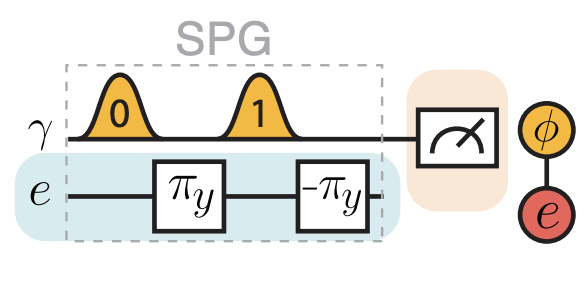

In [8]:
Image(filename='FiguresJupyter/SingleQubit_rotation.png')

In [22]:
## the original parameters
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real' set by the cavity-QED parameters
                'tdinoise': - 0.1, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid, b16_mwfid] # default fidelities
               }
mu = 0.05

In [10]:
phi1 = [0, np.pi/4, np.pi/2, 3*np.pi/4]
phi2 = 0
phi3 = 0

In [50]:
cluster_state_length = 1
n_rounds = 100

rates_apd1_apd2 = np.empty((0, 2), dtype=float)
rho_phi_n_array_s = np.empty((0, n_rounds, 2, 2), dtype=complex)
rho_phi_n_array_cl = np.empty((0, n_rounds, 2, 2), dtype=complex)
nxnynz_cl_phi_array =  np.empty((0, n_rounds, 3), dtype=float)
nxnynz_s_phi_array =  np.empty((0, n_rounds, 3), dtype=float)
for j in range(len(phi1)):
    rho_n_array_cl = np.empty((0, 2, 2), dtype=complex)
    rho_n_array_s = np.empty((0, 2, 2), dtype=complex)
    rho_click = np.empty((0, 1), dtype=int)
    phi1e = phi1[j]
    print("Phi angle = ", phi1e)
    nxnynz_cl_array =  np.empty((0, 3), dtype=float)
    nxnynz_s_array =  np.empty((0, 3), dtype=float)
    for i in range(n_rounds): 
        if i%100 == 0:
            print(i)
        rho_init_xp = sim.single_node_electron_exp(rho_ideal_Xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
        rho_n_item_s = rho_init_xp[0]
        rho_n_item_cl = (qt.sigmaz()**(rho_init_xp[1]))*rho_init_xp[0]*(qt.sigmaz()**(rho_init_xp[1]))
        rho_n_array_s = np.vstack([rho_n_array_s, [rho_n_item_s]])
        rho_n_array_cl = np.vstack([rho_n_array_cl, [rho_n_item_cl]])
        nxnynz_cl = calculate_bloch_components(rho_n_item_cl)
        nxnynz_s = calculate_bloch_components(rho_n_item_s)
        nxnynz_cl_array =  np.vstack([nxnynz_cl_array, [nxnynz_cl]])
        nxnynz_s_array =  np.vstack([nxnynz_s_array, [nxnynz_s]])
    nxnynz_cl_phi_array =  np.vstack([nxnynz_cl_phi_array, [nxnynz_cl_array]])
    nxnynz_s_phi_array =  np.vstack([nxnynz_s_phi_array, [nxnynz_s_array]])
    mean_cl_nxnynz = np.mean(nxnynz_cl_array, axis =0)
    std_cl_nxnynz = np.std(nxnynz_cl_array, axis =0)/np.sqrt(n_rounds)
    mean_s_nxnynz = np.mean(nxnynz_s_array, axis =0)
    std_s_nxnynz = np.std(nxnynz_s_array, axis =0)/np.sqrt(n_rounds)
    print(mean_cl_nxnynz, std_cl_nxnynz)
    print(mean_s_nxnynz, std_s_nxnynz)
    rates_apd1_apd2 = np.append(rates_apd1_apd2, [rho_init_xp[2:4]])

    rho_phi_n_array_s = np.vstack([rho_phi_n_array_s, [rho_n_array_s]])
    rho_phi_n_array_cl = np.vstack([rho_phi_n_array_cl, [rho_n_array_cl]])

Phi angle =  0
0
[ 0.91781155  0.08416893 -0.01857793] [0.00755834 0.00321399 0.03183244]
[ 0.46734203  0.01666539 -0.01857793] [0.07935252 0.00885418 0.03183244]
Phi angle =  0.7853981633974483
0
[0.55873522 0.71437125 0.02296606] [0.0199728  0.01645016 0.02529669]
[ 0.25492822 -0.06014463  0.02296606] [0.05358059 0.07305954 0.02529669]
Phi angle =  1.5707963267948966
0
[-0.09768679  0.89922632  0.00394182] [0.03192788 0.00374198 0.01845068]
[ 0.31256832 -0.00453413  0.00394182] [0.01173996 0.08999931 0.01845068]
Phi angle =  2.356194490192345
0
[-0.70765998  0.56557238 -0.00442542] [0.01455575 0.01631475 0.0295207 ]
[ 0.31748105 -0.01630183 -0.00442542] [0.06489803 0.05884076 0.0295207 ]


In [27]:
fid_err_phi =  np.empty((0, 2), dtype=float)
fid_ave_phi =  np.empty((0, 2), dtype=float)
for j in range(len(phi1)):
    U = rz(phi1[j])
    el_rho_final_ideal = U*rho_ideal_Xp*U.dag()
    fid_n =  np.empty((0, 2), dtype=float)
    for k in range(n_rounds):
        fid = (qt.fidelity(qt.Qobj(rho_phi_n_array_cl[j][k]), el_rho_final_ideal))**2
        fid_n = np.append(fid_n, fid)
    fid_ave = np.mean(fid_n, axis = 0)
    # this is only the variability of the measurement
    fid_ave_std = np.std(fid_n, axis = 0)/(np.sqrt(n_rounds))
    fid_ave_phi = np.append(fid_ave_phi, fid_ave)
    fid_err_phi = np.append(fid_err_phi, fid_ave_std)

In [28]:
## print the pauli components

print(np.mean(nxnynz_cl_phi_array, axis = 1))
print(np.std(nxnynz_cl_phi_array, axis = 1)/np.sqrt(n_rounds))
print(np.mean(nxnynz_s_phi_array, axis = 1))
print(np.std(nxnynz_s_phi_array, axis = 1)/np.sqrt(n_rounds))

[[ 0.92337941 -0.08821863 -0.02500928]
 [ 0.70922567  0.5762673  -0.04972562]
 [ 0.14311316  0.89283098  0.00336878]
 [-0.58944947  0.69026763 -0.0647741 ]]
[[0.00651809 0.00340849 0.02984546]
 [0.01419838 0.01694448 0.02614766]
 [0.03084069 0.00379971 0.02042899]
 [0.0198926  0.01678698 0.0245325 ]]
[[ 0.36006486 -0.00442508 -0.02500928]
 [ 0.2741785  -0.03622671 -0.04972562]
 [ 0.32057542  0.16761194  0.00336878]
 [ 0.32376775 -0.00528065 -0.0647741 ]]
[[0.08527786 0.00944708 0.02984546]
 [0.0669318  0.05995692 0.02614766]
 [0.0113259  0.08777797 0.02042899]
 [0.05312218 0.07103674 0.0245325 ]]


In [29]:
fid = np.mean(fid_ave_phi, axis = 0)
fiderr = np.sqrt(np.sum(fid_err_phi**2)/len(fid_err_phi))
print('Fidelity over all phis = ', fid, "+-",  fiderr)

Fidelity over phi =  0.9537609855385365 +- 0.0028226669762793084


#### Blindness
##### Calculate the information leakage btetween over four different phis = 0, pi/4, pi/2, 3pi/4

In [31]:
rho_ave_phi_array =  np.empty((0, 2, 2), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

mean_nxnynz = np.mean(nxnynz_s_phi_array, axis =1)
std_nxnynz = np.std(nxnynz_s_phi_array, axis =1)/np.sqrt(n_rounds)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis = [(1/2)*(1 -np.sqrt(np.sum(mean_nxnynz**2, axis = 1))), (1/2)*(1 +np.sqrt(np.sum(mean_nxnynz**2, axis = 1)))]
eigen_phis_std = np.array([eigenvalue_uncertainty(mean_nxnynz[i], std_nxnynz[i]) for i in range(len(mean_nxnynz))])

rho_ave_phi_array = np.mean(rho_phi_n_array_s, axis = 1)
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)
nxnynz_tot = np.array([calculate_bloch_components(qt.Qobj(rho_ave_tot))])
nxnynz_tot_std = np.sqrt(np.sum(eigen_phis_std**2))/len(eigen_phis_std)

# std of variability of eigenvalues of rho tot
std_eigen_tot = eigenvalue_uncertainty(nxnynz_tot.ravel(), [nxnynz_tot_std,nxnynz_tot_std,nxnynz_tot_std])
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())

hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])
rho_tot_sigma_lambdas = (std_eigen_tot, std_eigen_tot)
rho_tot_lambdas = (eigen_tot[0], eigen_tot[1])
rho_lambdas = list(zip(eigen_phis[0], eigen_phis[1]))
rho_sigma_lambdas =  [(value, value) for value in eigen_phis_std]

hv_std = holevo_bound_uncertainty_1q(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)

print('Holevo bound is = ', hv_tot, hv_std)


Holevo bound is =  0.004215816292248653 0.010692613022173022


### Create a plot of a rotation as a function of phi

In [11]:
phi1 = [0, np.pi/8, 2*np.pi/8, 3*np.pi/8, 4*np.pi/8, 5*np.pi/8, 6*np.pi/8, 7*np.pi/8, 8*np.pi/8]
phi2 = 0
phi3 = 0
cluster_state_length = 1
n_rounds = 100

rates_apd1_apd2 = np.empty((0, 2), dtype=float)
rho_phi_n_array_s = np.empty((0, n_rounds, 2, 2), dtype=complex)
rho_phi_n_array_cl = np.empty((0, n_rounds, 2, 2), dtype=complex)
nxnynz_cl_phi_array =  np.empty((0, n_rounds, 3), dtype=float)
nxnynz_s_phi_array =  np.empty((0, n_rounds, 3), dtype=float)
for j in range(len(phi1)):
    rho_n_array_cl = np.empty((0, 2, 2), dtype=complex)
    rho_n_array_s = np.empty((0, 2, 2), dtype=complex)
    rho_click = np.empty((0, 1), dtype=int)
    phi1e = phi1[j]
    print("Phi angle = ", phi1e)
    nxnynz_cl_array =  np.empty((0, 3), dtype=float)
    nxnynz_s_array =  np.empty((0, 3), dtype=float)
    for i in range(n_rounds): 
        rho_init_xp = sim.single_node_electron_exp(rho_ideal_Xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
        rho_n_item_s = rho_init_xp[0]
        rho_n_item_cl = (qt.sigmaz()**(rho_init_xp[1]))*rho_init_xp[0]*(qt.sigmaz()**(rho_init_xp[1]))
        rho_n_array_s = np.vstack([rho_n_array_s, [rho_n_item_s]])
        rho_n_array_cl = np.vstack([rho_n_array_cl, [rho_n_item_cl]])
        nxnynz_cl = calculate_bloch_components(rho_n_item_cl)
        nxnynz_s = calculate_bloch_components(rho_n_item_s)
        nxnynz_cl_array =  np.vstack([nxnynz_cl_array, [nxnynz_cl]])
        nxnynz_s_array =  np.vstack([nxnynz_s_array, [nxnynz_s]])
    nxnynz_cl_phi_array =  np.vstack([nxnynz_cl_phi_array, [nxnynz_cl_array]])
    nxnynz_s_phi_array =  np.vstack([nxnynz_s_phi_array, [nxnynz_s_array]])
    mean_cl_nxnynz = np.mean(nxnynz_cl_array, axis =0)
    std_cl_nxnynz = np.std(nxnynz_cl_array, axis =0)/np.sqrt(n_rounds)
    mean_s_nxnynz = np.mean(nxnynz_s_array, axis =0)
    std_s_nxnynz = np.std(nxnynz_s_array, axis =0)/np.sqrt(n_rounds)
    print(mean_cl_nxnynz, std_cl_nxnynz)
    print(mean_s_nxnynz, std_s_nxnynz)
    rates_apd1_apd2 = np.append(rates_apd1_apd2, [rho_init_xp[2:4]])

    rho_phi_n_array_s = np.vstack([rho_phi_n_array_s, [rho_n_array_s]])
    rho_phi_n_array_cl = np.vstack([rho_phi_n_array_cl, [rho_n_array_cl]])

Phi angle =  0
[0.90300405 0.09249471 0.04188623] [0.01282242 0.00358244 0.03298805]
[ 0.26691124 -0.00389801  0.04188623] [0.08721331 0.00991134 0.03298805]
Phi angle =  0.39269908169872414
[ 0.8162666   0.41814553 -0.03355585] [0.01067838 0.01368553 0.02899118]
[ 0.33264976  0.01596901 -0.03355585] [0.07530193 0.04396817 0.02899118]
Phi angle =  0.7853981633974483
[ 0.57570516  0.70043755 -0.01746696] [0.01974295 0.01651973 0.02580765]
[ 0.29186239 -0.0189852  -0.01746696] [0.05340704 0.07194043 0.02580765]
Phi angle =  1.1780972450961724
[ 0.31915413  0.84521336 -0.01606401] [0.02890934 0.00900718 0.02202392]
[ 0.35969376  0.17210517 -0.01606401] [0.02367589 0.08323932 0.02202392]
Phi angle =  1.5707963267948966
[-0.0514899   0.89349775 -0.05598155] [0.03209528 0.00427726 0.02169419]
[ 0.3082094   0.06869132 -0.05598155] [0.01032903 0.08918796 0.02169419]
Phi angle =  1.9634954084936207
[-0.41841928  0.79664118 -0.0205084 ] [0.02622359 0.01406129 0.02379298]
[ 0.29563284  0.02413492

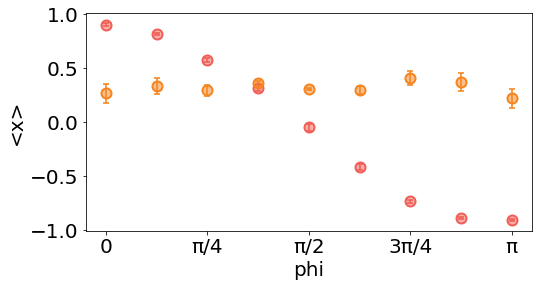

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# Assuming phi1, c1, c2, nxnynz_cl_phi_array, nxnynz_s_phi_array, and n_rounds are defined elsewhere

x_mean_cl = np.mean(nxnynz_cl_phi_array, axis=1)
y_std_cl = np.std(nxnynz_cl_phi_array, axis=1) / np.sqrt(n_rounds)

x_mean_s = np.mean(nxnynz_s_phi_array, axis=1)
y_std_s = np.std(nxnynz_s_phi_array, axis=1) / np.sqrt(n_rounds)

# Sample data
x = phi1
y_cl = x_mean_cl[:, 0]
yerr_cl = y_std_cl[:, 0]  # Error values

y_s = x_mean_s[:, 0]
yerr_s = y_std_s[:, 0]    # Error values

# Define colors with alpha values
facecolor_cl = colors.to_rgba(c1, alpha=0.5)
edgecolor_cl = colors.to_rgba(c1, alpha=1.0)
errorbar_color_cl = colors.to_rgba(c1, alpha=0.8)

facecolor_s = colors.to_rgba(c2, alpha=0.5)
edgecolor_s = colors.to_rgba(c2, alpha=1.0)
errorbar_color_s = colors.to_rgba(c2, alpha=0.8)

# Create a new figure with specified size
plt.figure(figsize=(8, 4))  # Width and height in inches

# Create the error bar plot
plt.errorbar(
    x, y_cl, yerr=yerr_cl,
    fmt='o',
    markersize=10,
    markerfacecolor=facecolor_cl,
    markeredgecolor=edgecolor_cl,
    ecolor=errorbar_color_cl,
    capsize=3,
    elinewidth=2,
    markeredgewidth=2
)

plt.errorbar(
    x, y_s, yerr=yerr_s,
    fmt='o',
    markersize=10,
    markerfacecolor=facecolor_s,
    markeredgecolor=edgecolor_s,
    ecolor=errorbar_color_s,
    capsize=3,
    elinewidth=2,
    markeredgewidth=2
)

# Customize the plot
plt.xlabel('phi', fontsize=20)
plt.ylabel('<x>', fontsize=20)
# plt.title('Scatter Plot with Error Bars')

# Set specific x and y ticks
x_ticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
y_ticks = [-1, -0.5, 0, 0.5, 1]

# Optionally, set custom labels for the ticks
x_tick_labels = ['0', 'π/4', 'π/2', '3π/4', 'π']
plt.xticks(x_ticks, x_tick_labels, fontsize=20)
plt.yticks(y_ticks, fontsize=20)

# Save the plot as a PNG file
plt.savefig('/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/Figures/1qubit_rot_vsPhi.png', dpi=400, bbox_inches='tight')

# Display the plot
plt.show()


## B16 universal single qubit rotations

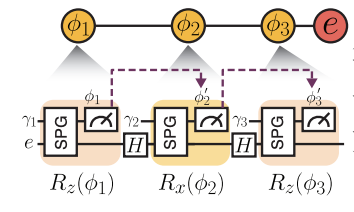

In [60]:
Image(filename='FiguresJupyter/SingleQubit_universal.png')

#### Identity

In [10]:
b16_mwfid_unitary = 0.99
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.4, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid_unitary, b16_mwfid_unitary] # default fidelities
               }
mu = 0.2
phi_array  = [0, 0, 0]
cluster_state_length = 3


In [11]:
n_rounds = 30 # estimate for 6 hrs of run
el_rho_final_ideal = psi_ideal_Yp

rho_n_array_cl_id = np.empty((0, 2, 2), dtype=complex)
rho_n_array_s_id = np.empty((0, 2, 2), dtype=complex)
nxnynz_cl_array_id =  np.empty((0, 3), dtype=float)
nxnynz_s_array_id =  np.empty((0, 3), dtype=float)
fid_n =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = sim.single_qubit_universal_blind_gate_with_feedback(rho_ideal_Yp, imperfections, cluster_state_length, phi_array, mu)
    rho_s = rho_output[0]
    rho_cl = rho_output[1]
    rho_n_array_s_id = np.vstack([rho_n_array_s_id, [rho_s]])
    rho_n_array_cl_id = np.vstack([rho_n_array_cl_id, [rho_cl]])
    fid = (qt.fidelity(qt.Qobj(rho_cl), el_rho_final_ideal))**2
    fid_n = np.append(fid_n, fid)
    nxnynz_cl = calculate_bloch_components(rho_s)
    nxnynz_s = calculate_bloch_components(rho_cl)
    nxnynz_cl_array_id = np.vstack([nxnynz_cl_array_id, [nxnynz_cl]])
    nxnynz_s_array_id = np.vstack([nxnynz_s_array_id, [nxnynz_s]])
nxnynz_tot_cl_id = np.mean(nxnynz_cl_array_id, axis = 0)
nxnynz_tot_s_id = np.mean(nxnynz_s_array_id, axis = 0)
nxnynz_tot_std_cl_id = np.std(nxnynz_cl_array_id, axis = 0)/np.sqrt(n_rounds)
nxnynz_tot_std_s_id = np.std(nxnynz_s_array_id, axis = 0)/np.sqrt(n_rounds)

fid_ave_id = np.mean(fid_n, axis = 0)
fid_ave_std_id = np.std(fid_n, axis = 0)/(np.sqrt(n_rounds))

print(nxnynz_tot_cl_id)
print(nxnynz_tot_std_cl_id)

print(nxnynz_tot_s_id)
print(nxnynz_tot_std_s_id)

print("Fidelity of a universal Identity gate = ", fid_ave_id, "+-", fid_ave_std_id)


[0.03344129 0.07312211 0.07204078]
[0.08139116 0.09598656 0.0606977 ]
[-0.30497776  0.51101844 -0.02904986]
[0.05967761 0.02621043 0.06187954]
Fidelity of a universal Identity gate =  0.7555092223234113 +- 0.013105214756201846


##### FIdelity of Identity

In [12]:
U_transform_ztoy = qt.Qobj([[1, 1j], [1j, 1]]) / (2 ** 0.5)
print(U_transform_ztoy*rho_ideal_Yp*U_transform_ztoy.dag())

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]


TRue


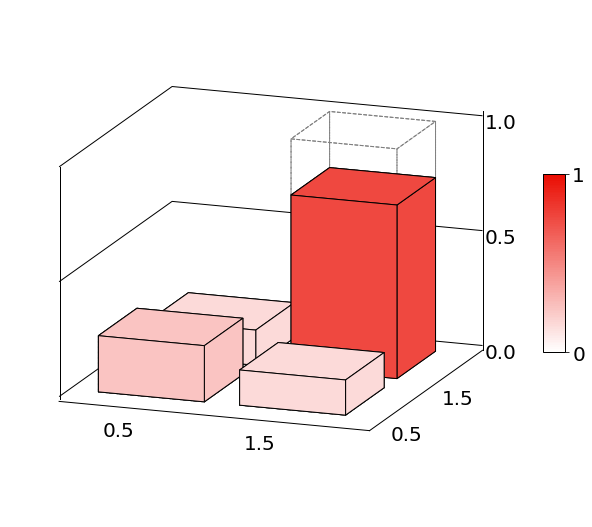

In [90]:
rho = np.mean(rho_n_array_cl_id, axis = 0)
# from Z to Y basis
rho_y = U_transform_ztoy * rho * U_transform_ztoy.dag()
plot_from_rho_Identity(rho_y, "", "Identity_client.png", "Reds", client=True)

hi


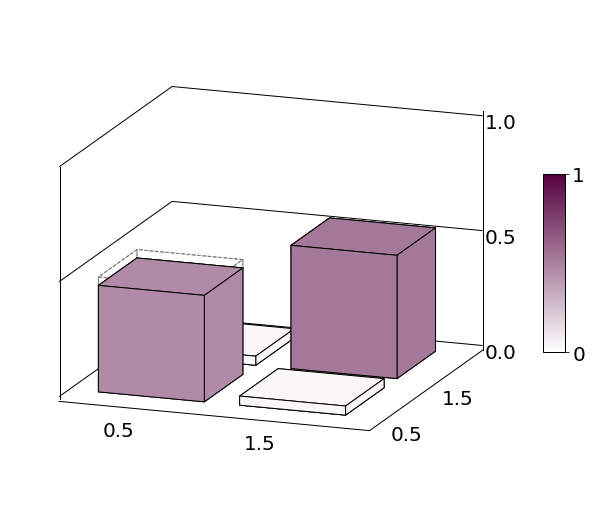

In [92]:
rho = np.mean(rho_n_array_s_id, axis = 0)
# from Z to Y basis
rho_y = U_transform_ztoy * rho * U_transform_ztoy.dag()
plot_from_rho_Identity(rho_y, "", "Identity_sever", 'Greens', False)

#### Hadamart

In [111]:
b16_mwfid_unitary = 0.99
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.4, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid_unitary, b16_mwfid_unitary] # default fidelities
               }
mu = 0.2
phi_array  = [np.pi/2, np.pi/2, np.pi/2]

cluster_state_length = 3


In [133]:
def plot_from_rho_Had(rho, title, filename, color, client):

    if client == True:
        target = (241/255, 95/255, 88/255)
        start = (1,1,1)
        diff = np.array([1-241/255, 1-95/255, 1-88/255])
        diff = diff/np.max(diff)

    elif client == False:
        target = (116/255, 48/255, 98/255)
        start = (1,1,1)
        diff = np.array([1-116/255, 1-48/255, 1-98/255])
        diff = diff/np.max(diff)

    plt.rcParams.update({'font.size': 20, 'axes.linewidth': 1})
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(azim=-70, elev=15)
    ax.set_proj_type('ortho')

    xedges = np.array([0, 1, 2])
    yedges = np.array([0, 1, 2])

    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = dy = 0.75 * np.ones_like(zpos)

    hist = np.zeros([2,2])

    for ii in range(2):
        for jj in range(2):
            hist[ii,jj] = np.abs(rho[ii,jj])
            # print(hist[ii,jj])

    dz = hist.ravel()

    cmap = plt.cm.get_cmap(color) # Get desired colormap - you can change this!

    N = 100
    color_list = []
    bounds = np.linspace(0,1,N)

    for ii in range(N):
        color_list.append((start[0] - diff[0]*ii/N, start[1] - diff[1]*ii/N, start[2] - diff[2]*ii/N))

    cmap = mpl.colors.ListedColormap(color_list)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


    max_height = 1  # get range of colorbars so we can normalize
    min_height = 0
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', linestyle='-', linewidth=1, edgecolor='k', color=rgba, shade=False)


    xedges = np.array([0, 1, 2])
    yedges = np.array([0, 1, 2])

    if client == True:
        print("TRue")
        hist = np.array([[1, 0],
                        [0, 0]])

    elif client == False:
        print("hi")
        hist = np.array([[0.5, 0],
                        [0, 0.5]])
    

    zpos_hist = np.abs(np.real(rho[:]))
    dz_hist = hist - np.abs(np.real(rho[:]))
    # print('zpos_hist', zpos_hist)
    # print('dz_hist', dz_hist)


    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = zpos_hist.ravel()

    # Construct arrays with the dimensions for the 4 bars.
    dx = dy = 0.75 * np.ones_like(zpos)
    dz = hist.ravel()

    dz = dz_hist.ravel()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='min', linestyle='--', linewidth=1, edgecolor='grey', color=(0, 0, 1, 0))


    ax.plot([0.05,0.05],[0.05,0.05],[-0.01,1], color='k', linewidth=1)
    #ax.plot([0.0,0.0],[2.3,4.3],[0,0.5], color='k', linewidth=1.5)


    ax.set_zticks([0, 0.5, 1])
    ax.set_zlim([0,1])
    # ax.set_zticklabels(["0", "", "1"])

    ax.set_xticks([0.5, 1.5])
    ax.set_xlim([0.09,2.2])
    # ax.set_xticklabels(["$-Y$", "$+Y$"])

    ax.set_yticks([0.5, 1.5])
    ax.set_ylim([0.09,2.2])
    # ax.set_yticklabels(["$-Y$", "$+Y$"])

    ax.w_xaxis.set_pane_color((0, 0, 0, 0))
    ax.w_yaxis.set_pane_color((0, 0, 0, 0))
    ax.w_zaxis.set_pane_color((0, 0, 0, 0))
    ax.w_zaxis.edge = 0

    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (0,0,0,1)
    ax.zaxis._axinfo["grid"]['linewidth'] =  1
    ax.zaxis._axinfo["tick"]['lenght'] =  0

    ax.xaxis.set_tick_params(length=0)
    ax.tick_params(color=(0,0,0,0))

    ax.w_zaxis.linewidth =  1
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, fraction=0.04, pad=0.04, aspect=8)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["0", "1"])

    ax.set_title(title)

    plt.show()
    fig.savefig(filename, bbox_inches='tight', dpi=300)

In [128]:
n_rounds = 30 # estimate for 6 hrs of run
el_rho_final_ideal = rho_ideal_Ym

rho_n_array_cl_had = np.empty((0, 2, 2), dtype=complex)
rho_n_array_s_had = np.empty((0, 2, 2), dtype=complex)
nxnynz_cl_array_had =  np.empty((0, 3), dtype=float)
nxnynz_s_array_had =  np.empty((0, 3), dtype=float)
fid_n =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = sim.single_qubit_universal_blind_gate_with_feedback(rho_ideal_Yp, imperfections, cluster_state_length, phi_array, mu)
    rho_s = rho_output[0]
    rho_cl = rho_output[1]
    rho_n_array_s_had = np.vstack([rho_n_array_s_had, [rho_s]])
    rho_n_array_cl_had = np.vstack([rho_n_array_cl_had, [rho_cl]])
    fid = (qt.fidelity(qt.Qobj(rho_cl), el_rho_final_ideal))**2
    fid_n = np.append(fid_n, fid)
    nxnynz_cl = calculate_bloch_components(rho_s)
    nxnynz_s = calculate_bloch_components(rho_cl)
    nxnynz_cl_array_had = np.vstack([nxnynz_cl_array_had, [nxnynz_cl]])
    nxnynz_s_array_had = np.vstack([nxnynz_s_array_had, [nxnynz_s]])
nxnynz_tot_cl_had = np.mean(nxnynz_cl_array_had, axis = 0)
nxnynz_tot_s_had = np.mean(nxnynz_s_array_had, axis = 0)
nxnynz_tot_std_cl_had = np.std(nxnynz_cl_array_had, axis = 0)/np.sqrt(n_rounds)
nxnynz_tot_std_s_had = np.std(nxnynz_s_array_had, axis = 0)/np.sqrt(n_rounds)

fid_ave_had = np.mean(fid_n, axis = 0)
fid_ave_std_had = np.std(fid_n, axis = 0)/(np.sqrt(n_rounds))

print(nxnynz_tot_cl_had)
print(nxnynz_tot_std_cl_had)

print(nxnynz_tot_s_had)
print(nxnynz_tot_std_s_had)

print("Fidelity of a universal Identity gate = ", fid_ave_had, "+-", fid_ave_std_had)


[-0.04140968 -0.03090967  0.12299746]
[0.09072347 0.0848687  0.08154555]
[-0.35760679 -0.37775728  0.16972222]
[0.06344409 0.04977809 0.0787005 ]
Fidelity of a universal Identity gate =  0.6888786482453462 +- 0.024889043570977216


TRue


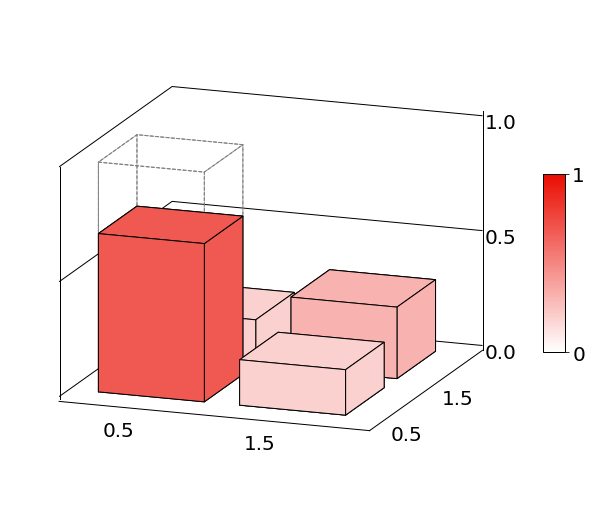

In [134]:
rho = np.mean(rho_n_array_cl_had, axis = 0)
# from Z to Y basis
rho_y = U_transform_ztoy * rho * U_transform_ztoy.dag()
plot_from_rho_Had(rho_y, "", "Hadamart_client", 'Reds', True)

hi


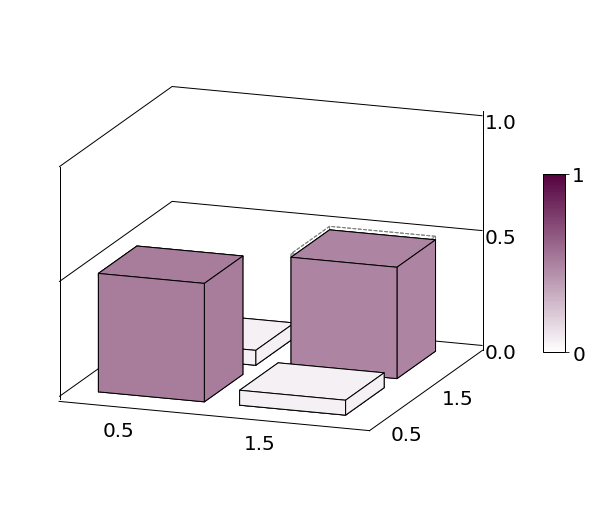

In [135]:
rho = np.mean(rho_n_array_s_had, axis = 0)
# from Z to Y basis
rho_y = U_transform_ztoy * rho * U_transform_ztoy.dag()
plot_from_rho_Had(rho_y, "", "Hadamart_sever", 'Greens', False)

#### T sqrt(X) T

In [136]:
b16_mwfid_unitary = 0.99
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.4, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid_unitary, b16_mwfid_unitary] # default fidelities
               }
mu = 0.2
phi_array  = [np.pi/4, np.pi/2, np.pi/4]

cluster_state_length = 3

In [137]:
TsqXT = rz(np.pi/4)*rx(np.pi/2)*rz(np.pi/4)
el_rho_final_ideal = TsqXT*rho_ideal_Yp*TsqXT.dag()
print(el_rho_final_ideal)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.85355339+0.j   -0.25      +0.25j]
 [-0.25      -0.25j  0.14644661+0.j  ]]


In [120]:
n_rounds = 30 # estimate for 6 hrs of run

rho_n_array_cl_txt = np.empty((0, 2, 2), dtype=complex)
rho_n_array_s_txt = np.empty((0, 2, 2), dtype=complex)
nxnynz_cl_array_txt =  np.empty((0, 3), dtype=float)
nxnynz_s_array_txt =  np.empty((0, 3), dtype=float)
fid_n =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = sim.single_qubit_universal_blind_gate_with_feedback(rho_ideal_Yp, imperfections, cluster_state_length, phi_array, mu)
    rho_s = rho_output[0]
    rho_cl = rho_output[1]
    rho_n_array_s_txt = np.vstack([rho_n_array_s_txt, [rho_s]])
    rho_n_array_cl_txt = np.vstack([rho_n_array_cl_txt, [rho_cl]])
    fid = (qt.fidelity(qt.Qobj(rho_cl), el_rho_final_ideal))**2
    fid_n = np.append(fid_n, fid)
    nxnynz_cl = calculate_bloch_components(rho_s)
    nxnynz_s = calculate_bloch_components(rho_cl)
    nxnynz_cl_array_txt = np.vstack([nxnynz_cl_array_txt, [nxnynz_cl]])
    nxnynz_s_array_txt = np.vstack([nxnynz_s_array_txt, [nxnynz_s]])
nxnynz_tot_cl_txt = np.mean(nxnynz_cl_array_txt, axis = 0)
nxnynz_tot_s_txt = np.mean(nxnynz_s_array_txt, axis = 0)
nxnynz_tot_std_cl_txt = np.std(nxnynz_cl_array_txt, axis = 0)/np.sqrt(n_rounds)
nxnynz_tot_std_s_txt = np.std(nxnynz_s_array_txt, axis = 0)/np.sqrt(n_rounds)

fid_ave_txt = np.mean(fid_n, axis = 0)
fid_ave_std_txt = np.std(fid_n, axis = 0)/(np.sqrt(n_rounds))

print(nxnynz_tot_cl_txt)
print(nxnynz_tot_std_cl_txt)

print(nxnynz_tot_s_txt)
print(nxnynz_tot_std_s_txt)

print("Fidelity of a universal Identity gate = ", fid_ave_txt, "+-", fid_ave_std_txt)


[0.03664483 0.08867062 0.11449686]
[0.07605466 0.09139116 0.08754773]
[-0.3385107  -0.42473261  0.21805802]
[0.04482659 0.05100164 0.08072554]
Fidelity of a universal Identity gate =  0.7679059833060153 +- 0.029503562629352855


TRue


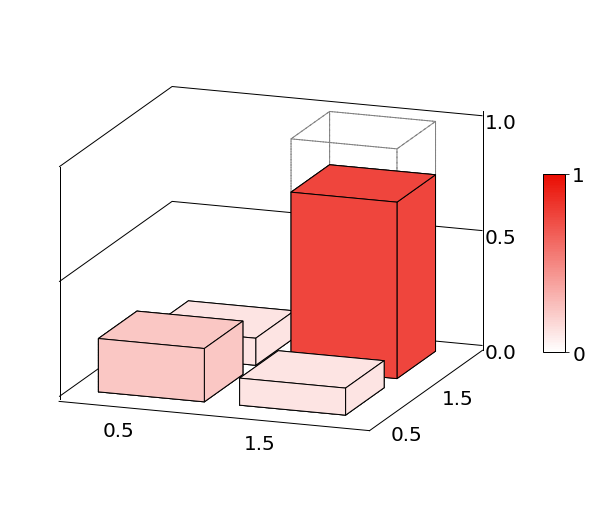

In [142]:
rho = np.mean(rho_n_array_cl_txt, axis = 0)
# to TXTy basis 
U_txt = U_transform_ztoy*TsqXT.dag()
rho_y = U_txt*rho*U_txt.dag()
plot_from_rho_Identity(rho_y, "", "TXT_client", 'Blues', True)

hi


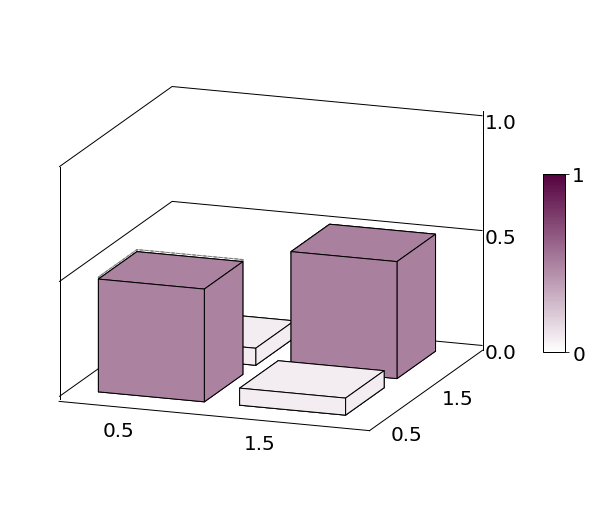

In [141]:
rho = np.mean(rho_n_array_s_txt, axis = 0)
# from Z to Y basis
rho_y = U_txt*rho*U_txt.dag()
plot_from_rho_TXT(rho_y, "", "TXT_server", 'Blues', False)

#### Blindness for the universal single qubit gate

In [145]:
rho_ave_phi_array =  np.empty((0, 2, 2), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

mean_nxnynz = np.concatenate(([nxnynz_tot_s_id], [nxnynz_tot_s_had], [nxnynz_tot_s_txt]), axis=0)
std_nxnynz = np.concatenate(([nxnynz_tot_std_s_id], [nxnynz_tot_std_s_had], [nxnynz_tot_std_s_txt]), axis=0)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis = [(1/2)*(1 -np.sqrt(np.sum(mean_nxnynz**2, axis = 1))), (1/2)*(1 +np.sqrt(np.sum(mean_nxnynz**2, axis = 1)))]
eigen_phis_std = np.array([eigenvalue_uncertainty(mean_nxnynz[i], std_nxnynz[i]) for i in range(len(mean_nxnynz))])

rho_ave_phi_array = np.array([np.mean(rho_n_array_s_id, axis = 0),np.mean(rho_n_array_s_had, axis = 0), np.mean(rho_n_array_s_txt, axis = 0)])
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)
nxnynz_tot = np.array([calculate_bloch_components(qt.Qobj(rho_ave_tot))])
nxnynz_tot_std = np.sqrt(np.sum(eigen_phis_std**2))/len(eigen_phis_std)

# std of variability of eigenvalues of rho tot
std_eigen_tot = eigenvalue_uncertainty(nxnynz_tot.ravel(), [nxnynz_tot_std,nxnynz_tot_std,nxnynz_tot_std])
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())

hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])

rho_tot_sigma_lambdas = (std_eigen_tot, std_eigen_tot)
rho_tot_lambdas = (eigen_tot[0], eigen_tot[1])
rho_lambdas = list(zip(eigen_phis[0], eigen_phis[1]))
print(rho_lambdas)
rho_sigma_lambdas =  [(value, value) for value in eigen_phis_std]
hv_std = holevo_bound_uncertainty_1q(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)

print('Holevo bound is = ', hv_tot, hv_std)


[(0.20209263949535178, 0.7979073605046483), (0.22641783160500617, 0.7735821683949938), (0.20736687434703616, 0.7926331256529638)]
Holevo bound is =  0.0023210395831750885 0.01087560074155486


## B16 Intranode two-qubit gate 

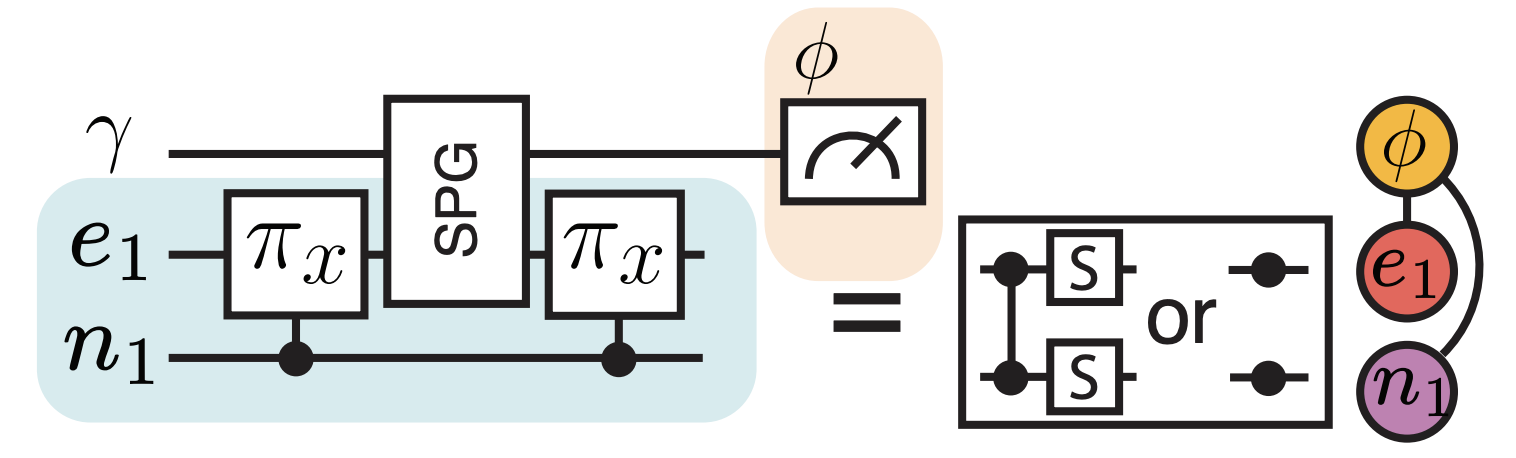

In [8]:
Image(filename='/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/Notebooks/FiguresJupyter/Intranode_2qubit.png')

In [134]:
b16_mwfid_unitary = 0.99
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.4, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid_unitary, b16_mwfid_unitary] # default fidelities
               }
mu = 0.25
eln_initial = qt.tensor(rho_ideal_Xp, rho_ideal_Xp)

In [135]:
SS = qt.tensor(s_gate(), s_gate())
CZ_gate = cphase(np.pi, N=2, control=0, target=1)
Ent_gate = SS*CZ_gate
el_rho_final_ideal_0 = eln_initial # identity operation
el_rho_final_ideal_pi2 =Ent_gate*eln_initial*Ent_gate.dag() # S1S2CZ
el_rho_final_ideal_pi4 =qt.ket2dm(qt.tensor((qt.basis(2,0) + np.exp(-1j*((np.pi/4)))*qt.basis(2,1)).unit(), qt.basis(2,1)) \
          + np.exp(-1j*(np.pi/4))*qt.tensor((qt.basis(2,0) + np.exp(1j*(np.pi/4))*qt.basis(2,1)).unit(), qt.basis(2,0))).unit()
el_rho_final_ideal_3pi4 =qt.ket2dm(qt.tensor((qt.basis(2,0) + np.exp(-1j*((3*np.pi/4)))*qt.basis(2,1)).unit(), qt.basis(2,1)) \
          + np.exp(-1j*(3*np.pi/4))*qt.tensor((qt.basis(2,0) + np.exp(1j*(3*np.pi/4))*qt.basis(2,1)).unit(), qt.basis(2,0))).unit()

##### Angle = 0

In [21]:
n_rounds = 400
rho_n_array_cl_0 = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0 = np.empty((0, 4, 4), dtype=complex)
fid_n_0 =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    if i%50==0:
        print(i)
    rho_output = sim.two_qubit_intranode_blind_gate(eln_initial, imperfections, 0, mu)
    rho_n_array_s_0 = np.vstack([rho_n_array_s_0, [rho_output[0]]])
    rho_n_array_cl_0 = np.vstack([rho_n_array_cl_0, [rho_output[1]]])
   
    fid = (qt.fidelity(qt.Qobj(rho_output[1]), el_rho_final_ideal_0))**2
    fid_n_0 = np.append(fid_n_0, fid)
    
fid_ave_0 = np.mean(fid_n_0, axis = 0)
fid_ave_std_0 = np.std(fid_n_0, axis = 0)/(np.sqrt(n_rounds))

print("Fidelity of an intranode gate = ", fid_ave_0, "+-", fid_ave_std_0)

0
50
100
150
200
250
300
350
Fidelity of an intranode gate =  0.8769085139448921 +- 0.0025487095263963884


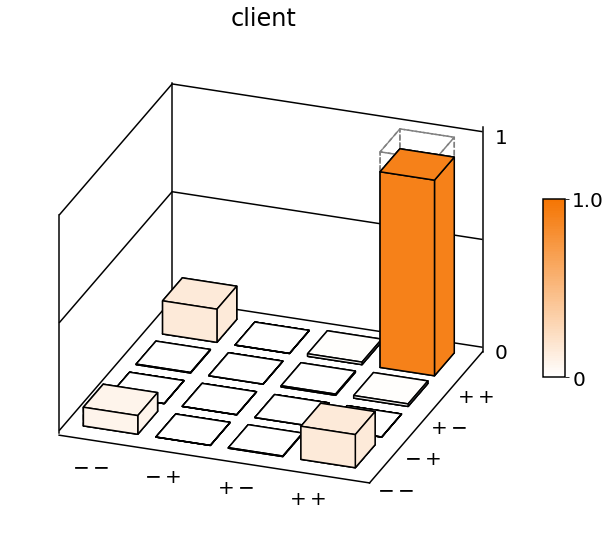

In [288]:
rho_ave_0 = np.mean(rho_n_array_cl_0, axis = 0)
oper_transform = qt.tensor(ry(np.pi/2), ry(np.pi/2))
rho = oper_transform*rho_ave_0*oper_transform.dag()
plot_from_rho_intranode_client(rho, 'client', 'intranode_phi_0_client.png', (246/255, 133/255, 32/255), False)

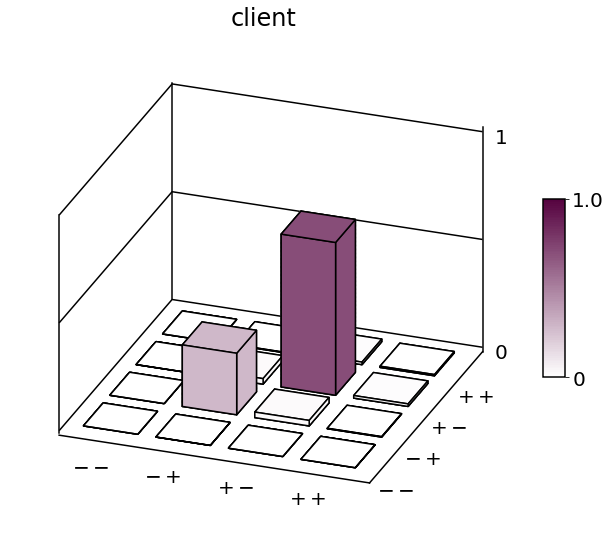

In [332]:
rho_ave_0 = np.mean(rho_n_array_s_0, axis = 0)
oper_transform = qt.tensor(ry(np.pi/2), ry(np.pi/2))
rho = oper_transform*rho_ave_0*oper_transform.dag()
plot_from_rho_intranode_server(rho, 'client', 'intranode_phi_0_server.png', (116/255, 48/255, 98/255), False)

##### Angle = pi4

In [144]:
n_rounds = 40
rho_n_array_cl_pi4 = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_pi4 = np.empty((0, 4, 4), dtype=complex)
fid_n_pi4=  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = sim.two_qubit_intranode_blind_gate(eln_initial, imperfections, np.pi/4, mu)
    rho_n_array_s_pi4 = np.vstack([rho_n_array_s_pi4, [rho_output[0]]])
    rho_n_array_cl_pi4 = np.vstack([rho_n_array_cl_pi4, [rho_output[1]]])
   
    fid = (qt.fidelity(qt.Qobj(rho_output[1]), el_rho_final_ideal_pi4))**2
    fid_n_pi4 = np.append(fid_n_pi4, fid)
    
fid_ave_pi4 = np.mean(fid_n_pi4, axis = 0)
fid_ave_std_pi4 = np.std(fid_n_pi4, axis = 0)/(np.sqrt(n_rounds))

print("Fidelity of an intranode gate = ", fid_ave_pi4, "+-", fid_ave_std_pi4)

Fidelity of an intranode gate =  0.9999292663099855 +- 1.4714424401587258e-09


##### Angle = pi/2

In [22]:
n_rounds = 400
rho_n_array_cl_pi2 = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_pi2 = np.empty((0, 4, 4), dtype=complex)
fid_n_pi2=  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    if i%50==0:
        print(i)
    rho_output = sim.two_qubit_intranode_blind_gate(eln_initial, imperfections, np.pi/2, mu)
    rho_n_array_s_pi2 = np.vstack([rho_n_array_s_pi2, [rho_output[0]]])
    rho_n_array_cl_pi2 = np.vstack([rho_n_array_cl_pi2, [rho_output[1]]])
   
    fid = (qt.fidelity(qt.Qobj(rho_output[1]), el_rho_final_ideal_pi2))**2
    fid_n_pi2 = np.append(fid_n_pi2, fid)
    
fid_ave_pi2 = np.mean(fid_n_pi2, axis = 0)
fid_ave_std_pi2 = np.std(fid_n_pi2, axis = 0)/(np.sqrt(n_rounds))

print("Fidelity of an intranode gate = ", fid_ave_pi2, "+-", fid_ave_std_pi2)

0
50
100
150
200
250
300
350
Fidelity of an intranode gate =  0.8761949597708957 +- 0.002585195967502472


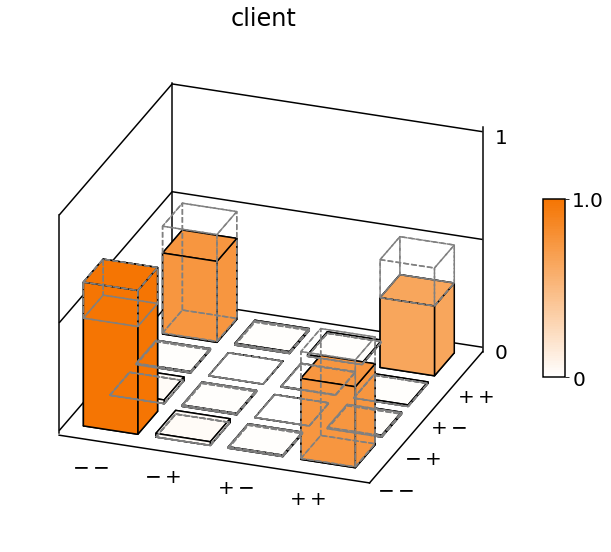

In [330]:
rho_ave_pi2 = np.mean(rho_n_array_cl_pi2, axis = 0)
oper_transform = qt.tensor(ry(np.pi/2), ry(np.pi/2))
rho = oper_transform*rho_ave_pi2*oper_transform.dag()
plot_from_rho_intranode_client(rho, 'client', 'intranode_phi_pi2_client.png', (246/255, 133/255, 32/255), True)

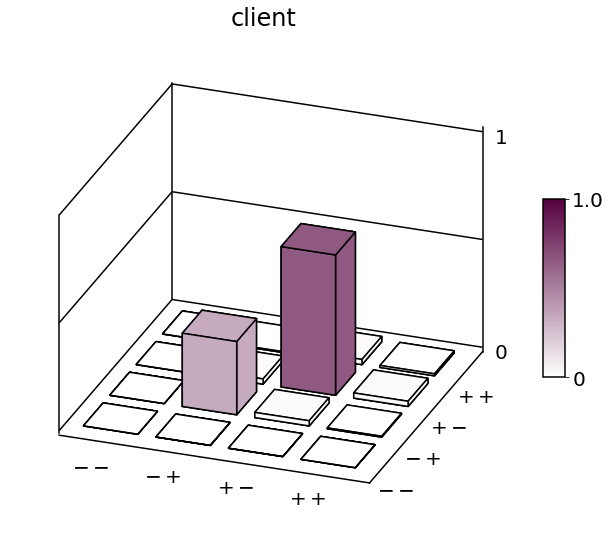

In [333]:
rho_ave_pi2 = np.mean(rho_n_array_s_pi2, axis = 0)
oper_transform = qt.tensor(ry(np.pi/2), ry(np.pi/2))
rho = oper_transform*rho_ave_pi2*oper_transform.dag()
plot_from_rho_intranode_server(rho, 'client', 'intranode_phi_pi2_server.png', (116/255, 48/255, 98/255), False)

##### Angle = 3pi/4

In [146]:
rho_n_array_cl_3pi4 = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_3pi4 = np.empty((0, 4, 4), dtype=complex)
fid_n_3pi4=  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = sim.two_qubit_intranode_blind_gate(eln_initial, imperfections, 3*np.pi/4, mu)
    rho_n_array_s_3pi4 = np.vstack([rho_n_array_s_3pi4, [rho_output[0]]])
    rho_n_array_cl_3pi4 = np.vstack([rho_n_array_cl_3pi4, [rho_output[1]]])
   
    fid = (qt.fidelity(qt.Qobj(rho_output[1]), el_rho_final_ideal_3pi4))**2
    fid_n_3pi4 = np.append(fid_n_3pi4, fid)
    
fid_ave_3pi4 = np.mean(fid_n_3pi4, axis = 0)
fid_ave_std_3pi4 = np.std(fid_n_3pi4, axis = 0)/(np.sqrt(n_rounds))

print("Fidelity of an intranode gate = ", fid_ave_3pi4, "+-", fid_ave_std_3pi4)

Fidelity of an intranode gate =  0.9999292826812468 +- 2.616005979284679e-09


#### Blindness of Intranode gate

#### Blindness over, 0, pi/4, pi/2, 3pi/4

In [ ]:
rho_ave_phi_array =  np.empty((0, 4, 4), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

rho_ave_phi_array = np.array([np.mean(rho_n_array_s_0, axis = 0),np.mean(rho_n_array_s_pi4, axis = 0), np.mean(rho_n_array_s_pi2, axis = 0), np.mean(rho_n_array_s_3pi4, axis = 0)])
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis_0 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_0]
eigen_phis_pi4 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_pi4]
eigen_phis_pi2 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_pi2]
eigen_phis_3pi4 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_3pi4]

factor = np.sqrt(len(eigen_phis_0))
eigen_phis = np.array([np.mean(eigen_phis_0, axis = 0),np.mean(eigen_phis_pi4, axis = 0),np.mean(eigen_phis_pi2, axis = 0),np.mean(eigen_phis_3pi4, axis = 0)])
eigen_phis_std = np.array([np.std(eigen_phis_0, axis = 0)/factor,np.std(eigen_phis_pi4, axis = 0)/factor,np.std(eigen_phis_pi2, axis = 0)/factor,np.std(eigen_phis_3pi4, axis = 0)/factor])

# # std of variability of eigenvalues of rho tot
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())
eigen_tot_std = np.sum(eigen_phis_std, axis = 0)
hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])

rho_tot_sigma_lambdas = eigen_tot_std
rho_tot_lambdas = eigen_tot
rho_lambdas = eigen_phis
rho_sigma_lambdas =  eigen_phis_std
hv_std = holevo_bound_uncertainty_2q(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)

print('Holevo bound is = ', hv_tot, hv_std)

#### BLindness over the 0 and pi/2

In [70]:
rho_ave_phi_array =  np.empty((0, 4, 4), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

rho_ave_phi_array = np.array([np.mean(rho_n_array_s_0, axis = 0), np.mean(rho_n_array_s_pi2, axis = 0)])
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis_0 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_0]
# eigen_phis_pi4 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_pi4]
eigen_phis_pi2 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_pi2]
# eigen_phis_3pi4 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_3pi4]

factor = np.sqrt(len(eigen_phis_0))
eigen_phis = np.array([np.mean(eigen_phis_0, axis = 0),np.mean(eigen_phis_pi2, axis = 0)])
eigen_phis_std = np.array([np.std(eigen_phis_0, axis = 0)/factor, np.std(eigen_phis_pi2, axis = 0)/factor])

# # std of variability of eigenvalues of rho tot
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())
eigen_tot_std = np.sum(eigen_phis_std, axis = 0)
hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])

rho_tot_sigma_lambdas = eigen_tot_std
rho_tot_lambdas = eigen_tot
rho_lambdas = eigen_phis
rho_sigma_lambdas =  eigen_phis_std
hv_std = holevo_bound_uncertainty_2q(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)

print('Holevo bound is = ', hv_tot, hv_std)

[6.43315611e-17 6.49976141e-03 3.65480179e-01 6.28020060e-01]
[6.91322798e-18 6.20327611e-18 1.62540366e-03 1.62540366e-03]
36.282479767865766 4.035989808291877 0.006543232400770149 -0.5348168297575873
0.0008693582919710745
[9.31073721e-17 8.54728749e-17 5.57540335e-02 9.44245967e-01]
[3.45148734e-18 3.14142035e-18 1.16886172e-03 1.16886172e-03]
35.91277723431993 35.99833143153934 1.8868055216845017 -0.9426314109690276
[9.96302973e-17 8.65413341e-17 5.48139478e-02 9.45186052e-01]
[3.46174064e-18 3.06185575e-18 4.56541947e-04 4.56541947e-04]
35.845064362142026 35.98590836723459 1.9038105961952896 -0.9436265098074963
[0.002465325565584855, 0.0009700765220588235]
Holevo bound is =  0.00128149238322528 0.0010929152540361334


#### Full Gate set tomography

In [659]:
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect', #'real'
                'tdinoise': 0, #np.pi/25, #'real'
                'mw': 'perfect', # or perfect
                'mw_noise': 0, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [1, 1] # default fidelities
               }
mu = 0.0000001
eln_initial = qt.tensor(rho_ideal_Xp, rho_ideal_Xp)

In [653]:
b16_mwfid_unitary = 0.99
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.4, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid_unitary, b16_mwfid_unitary] # default fidelities
               }
mu = 0.25
eln_initial = qt.tensor(rho_ideal_Xp, rho_ideal_Xp)

##### For phi = 0

In [654]:
## chi table of a perfect Identity gate
# Initialize a 16x16 chi matrix for the identity gate with all zeros
chi_identity = np.zeros((16, 16), dtype=complex)
# Set the (0, 0) entry to 1, corresponding to the identity operation
chi_identity[0, 0] = 1.0
chi_identity /= np.trace(chi_identity)

In [660]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.linalg import sqrtm

def generate_input_states():
    """
    Generates a set of tomographically complete input states for two qubits.
    """
    states = []
    # Define single-qubit states
    single_qubit_states = [
        basis(2, 0),                               # |0>
        basis(2, 1),                               # |1>
        (basis(2, 0) + basis(2, 1)).unit(),        # |+>
        (basis(2, 0) - basis(2, 1)).unit(),        # |->
        (basis(2, 0) + 1j * basis(2, 1)).unit(),   # |i+>
        (basis(2, 0) - 1j * basis(2, 1)).unit(),   # |i->
    ]

    # Generate two-qubit input states
    for psi1 in single_qubit_states:
        for psi2 in single_qubit_states:
            rho = ket2dm(tensor(psi1, psi2))
            # Flatten the dimensions
            rho = Qobj(rho.full(), dims=[[4], [4]])
            states.append(rho)

    return states

def simulate_process_0(input_states):
    """
    Simulates the process and returns the output density matrices.
    """
    # # Simulate the process (replace with your actual simulation function)
    # # For demonstration, we'll use an identity operation
    # output_states = []
    # for rho_in in input_states:
    #     # Apply identity operation (or replace with your process)
    #     rho_out = rho_in.copy()
    #     # Ensure the dimensions are flattened
    #     rho_out = Qobj(rho_out.full(), dims=[[4], [4]])
    #     output_states.append(rho_out)

        ### THIS IS AN IDENTITY OPERATOR ON ALL INPUT STATES

    # input_states = [qt.tensor((qt.basis(2, 0) - qt.basis(2, 1)).unit(),(qt.basis(2, 0) + qt.basis(2, 1)).unit())]
    n_rounds = 1

    ## the arrays across the input states
    rho_array_cl_0_states = np.empty((0, n_rounds, 4, 4), dtype=complex)
    rho_array_s_0_states = np.empty((0, n_rounds, 4, 4), dtype=complex)
    fid_0_states =  np.empty((0, 2), dtype=float)
    for i_s in input_states:
        ## the arrays within the rounds
        rho_n_array_cl_0 = np.empty((0, 4, 4), dtype=complex)
        rho_n_array_s_0 = np.empty((0, 4, 4), dtype=complex)
        fid_n_0 =  np.empty((0, 2), dtype=float)
        rho_n_0 =  np.empty((0, 4, 4), dtype=complex)
        for i in range(n_rounds):
            # if i%100==0:
            #     print(i)
            rho_output = sim.two_qubit_intranode_blind_gate(qt.Qobj(i_s, dims =[[2,2],[2,2]]), imperfections, 0, mu)
            
            rho_n_array_s_0 = np.vstack([rho_n_array_s_0, [rho_output[0]]])
            rho_n_array_cl_0 = np.vstack([rho_n_array_cl_0, [rho_output[1]]])
        
            fid = (qt.fidelity(qt.Qobj(rho_output[1]), el_rho_final_ideal_0))**2
            fid_n_0 = np.append(fid_n_0, fid)
        
        fid_ave_0 = np.mean(fid_n_0, axis = 0)
        fid_ave_std_0 = np.std(fid_n_0, axis = 0)/(np.sqrt(n_rounds))
        rho_array_s_0_states = np.vstack([rho_array_s_0_states, [rho_n_array_s_0]])
        rho_array_cl_0_states = np.vstack([rho_array_cl_0_states, [rho_n_array_cl_0]])

    rho_output_ave_states = np.mean(rho_array_cl_0_states, axis = 1)
    output_states = rho_output_ave_states

    return output_states

def simulate_process_1(input_states):
    """
    Simulates the process and returns the output density matrices.
    """
    # # Simulate the process (replace with your actual simulation function)
    # # For demonstration, we'll use an identity operation
    # output_states = []
    # for rho_in in input_states:
    #     # Apply identity operation (or replace with your process)
    #     rho_out = rho_in.copy()
    #     # Ensure the dimensions are flattened
    #     rho_out = Qobj(rho_out.full(), dims=[[4], [4]])
    #     output_states.append(rho_out)

        ### THIS IS AN IDENTITY OPERATOR ON ALL INPUT STATES

    # input_states = [qt.tensor((qt.basis(2, 0) - qt.basis(2, 1)).unit(),(qt.basis(2, 0) + qt.basis(2, 1)).unit())]
    n_rounds = 10

    ## the arrays across the input states
    rho_array_cl_0_states = np.empty((0, n_rounds, 4, 4), dtype=complex)
    rho_array_s_0_states = np.empty((0, n_rounds, 4, 4), dtype=complex)
    fid_0_states =  np.empty((0, 2), dtype=float)
    for i_s in input_states:
        ## the arrays within the rounds
        rho_n_array_cl_0 = np.empty((0, 4, 4), dtype=complex)
        rho_n_array_s_0 = np.empty((0, 4, 4), dtype=complex)
        fid_n_0 =  np.empty((0, 2), dtype=float)
        rho_n_0 =  np.empty((0, 4, 4), dtype=complex)
        for i in range(n_rounds):
            # if i%100==0:
            #     print(i)
            rho_output = sim.two_qubit_intranode_blind_gate(qt.Qobj(i_s, dims =[[2,2],[2,2]]), imperfections, np.pi/2, mu)
            
            rho_n_array_s_0 = np.vstack([rho_n_array_s_0, [rho_output[0]]])
            rho_n_array_cl_0 = np.vstack([rho_n_array_cl_0, [rho_output[1]]])
        
            fid = (qt.fidelity(qt.Qobj(rho_output[1]), el_rho_final_ideal_0))**2
            fid_n_0 = np.append(fid_n_0, fid)
        
        fid_ave_0 = np.mean(fid_n_0, axis = 0)
        fid_ave_std_0 = np.std(fid_n_0, axis = 0)/(np.sqrt(n_rounds))
        rho_array_s_0_states = np.vstack([rho_array_s_0_states, [rho_n_array_s_0]])
        rho_array_cl_0_states = np.vstack([rho_array_cl_0_states, [rho_n_array_cl_0]])

    rho_output_ave_states = np.mean(rho_array_cl_0_states, axis = 1)
    output_states = rho_output_ave_states

    return output_states

In [661]:

# Define the two-qubit Pauli basis operators
pauli_ops = [qeye(2), sigmax(), sigmay(), sigmaz()]
basis_ops = []
dim = 4  # For two qubits
for op1 in pauli_ops:
    for op2 in pauli_ops:
        op = tensor(op1, op2)
        # Flatten the dimensions
        op = Qobj(op.full(), dims=[[dim], [dim]])
        basis_ops.append(op)
num_basis = len(basis_ops)

# Load or define the input and output density matrices
input_states = generate_input_states()
output_states = simulate_process_0(input_states)

# Perform quantum process tomography to reconstruct the chi matrix
chi_matrix_0 = perform_qpt(input_states, output_states, basis_ops)

# Display the chi matrix
print("Chi Matrix:")
print(chi_matrix_0)

Chi Matrix:
Quantum object: dims = [[16], [16]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[ 1.00000000e+00-2.28165552e-19j -8.37662943e-18+1.01029372e-17j
   9.74101202e-18+4.62721783e-17j  1.29226920e-15-7.41699089e-18j
  -5.72807000e-17-2.08288666e-17j  1.57889781e-16+1.70051452e-17j
   1.11372336e-17+1.27374041e-16j  1.13871670e-17-5.79645501e-18j
  -4.60174649e-17-4.88256518e-17j  2.97120994e-17+1.71988042e-16j
  -2.62949191e-16+1.31723914e-17j  6.09840812e-17-4.01519780e-17j
   1.10489649e-15-4.36705977e-18j  1.59645075e-17+1.29782652e-17j
   3.15264532e-19-4.94789884e-18j  1.00687915e-15-2.09991556e-18j]
 [-3.72634993e-17-7.43555422e-18j -1.76629014e-16+1.73053286e-19j
  -1.34834498e-18-2.55833718e-16j  1.12158046e-16+1.16435267e-17j
  -1.92032468e-16+1.17006074e-17j  3.87327249e-17+8.86911468e-18j
   5.33791678e-18-8.13480683e-18j -6.51161823e-17-1.16084586e-18j
  -1.49142510e-17+5.62892117e-18j  1.82529871e-17+5.26491389e-18j
   7.24066825e-18+1.63507303e-17j  

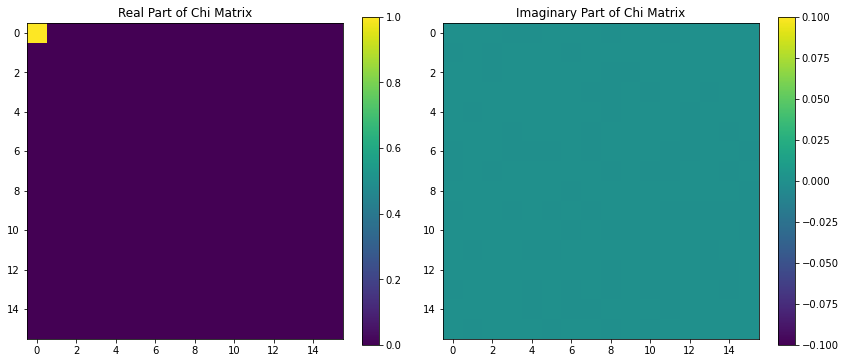

In [663]:

def plot_chi_matrix(chi):
    """
    Plots the real and imaginary parts of the chi matrix with adjusted color scales.
    """
    # If chi is a Qobj, convert it to a NumPy array
    if hasattr(chi, 'full'):
        chi_data = chi.full()
    else:
        chi_data = chi

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the real part
    im1 = axes[0].imshow(np.real(chi_data), cmap='viridis', interpolation='nearest')
    axes[0].set_title('Real Part of Chi Matrix')
    fig.colorbar(im1, ax=axes[0])

    # Plot the imaginary part with adjusted color scale
    # Set vmin and vmax to zero to display a uniform color
    im2 = axes[1].imshow(np.imag(chi_data), cmap='viridis', interpolation='nearest', vmin=0, vmax=0)
    axes[1].set_title('Imaginary Part of Chi Matrix')
    fig.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()
plot_chi_matrix(chi_matrix_0)

In [565]:
def process_fidelity(chi_exp, chi_ideal):
    """
    Computes the process fidelity between the experimental chi matrix and the ideal chi matrix.
    """
    return np.abs((qt.Qobj(chi_exp) * qt.Qobj(chi_ideal)).tr())

In [652]:
process_fidelity(qt.Qobj(chi_matrix_1), qt.Qobj(chi_identity))

(0.0823640184386663+1.3865483763897835e-11j)

In [641]:
process_fidelity(chi_matrix_1, qt.Qobj(chi_matrix_ent))

(0.8399509973018457-1.2047654540658923e-15j)

##### For phi = pi/2

Chi Matrix:
[[0.5+0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.5j]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
  0. +0.j  0. +0.j  0. +0.j

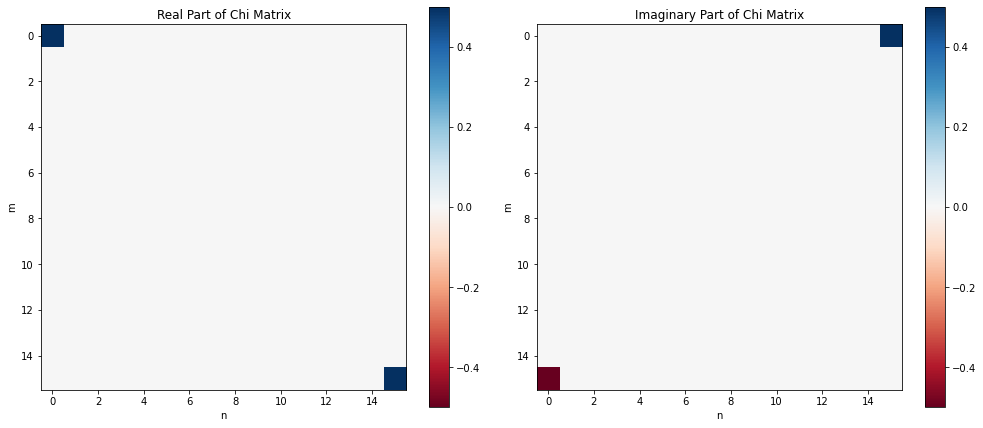

In [636]:
import numpy as np
import matplotlib.pyplot as plt

def composite_gate():
    """
    Constructs the composite gate U = CZ * (S ⊗ S)
    """
    # Define the S gate
    S = np.array([[1, 0],
                  [0, 1j]], dtype=complex)
    
    # Define CZ gate
    CZ = np.diag([1, 1, 1, -1])
    
    # Compute S ⊗ S
    S_tensor = np.kron(S, S)
    
    # Compute U = CZ * (S ⊗ S)
    U = np.dot(CZ, S_tensor)
    return U

def pauli_matrices():
    """
    Returns the single-qubit Pauli matrices.
    """
    I = np.array([[1, 0],
                  [0, 1]], dtype=complex)
    X = np.array([[0, 1],
                  [1, 0]], dtype=complex)
    Y = np.array([[0, -1j],
                  [1j, 0]], dtype=complex)
    Z = np.array([[1, 0],
                  [0, -1]], dtype=complex)
    return [I, X, Y, Z]

def pauli_basis():
    """
    Constructs the two-qubit Pauli basis operators.
    """
    paulis = pauli_matrices()
    basis_ops = []
    for op1 in paulis:
        for op2 in paulis:
            E = np.kron(op1, op2)
            basis_ops.append(E)
    return basis_ops

def compute_chi_matrix(U, basis_ops):
    """
    Computes the chi matrix for a unitary operation U in the given basis.
    """
    d = U.shape[0]
    u = []
    for E in basis_ops:
        u_k = (1 / d) * np.trace(np.dot(E.conj().T, U))
        u.append(u_k)
    u = np.array(u)
    chi = np.outer(u, u.conj())
    return chi

def plot_chi_matrix(chi):
    """
    Plots the real and imaginary parts of the chi matrix.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the real part
    im1 = axes[0].imshow(np.real(chi), cmap='RdBu', interpolation='nearest', vmin=-0.5, vmax=0.5)
    axes[0].set_title('Real Part of Chi Matrix')
    axes[0].set_xlabel('n')
    axes[0].set_ylabel('m')
    fig.colorbar(im1, ax=axes[0])

    # Plot the imaginary part
    im2 = axes[1].imshow(np.imag(chi), cmap='RdBu', interpolation='nearest', vmin=-0.5, vmax=0.5)
    axes[1].set_title('Imaginary Part of Chi Matrix')
    axes[1].set_xlabel('n')
    axes[1].set_ylabel('m')
    fig.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()

U = composite_gate()

# Define the two-qubit Pauli basis
basis_ops = pauli_basis()

# Compute the chi matrix
chi_matrix_ent = compute_chi_matrix(U, basis_ops)

# Display the chi matrix
print("Chi Matrix:")
print(chi_matrix_ent)

# Extract specified elements
chi_00 = chi_matrix_ent[0, 0]
chi_15_15 = chi_matrix_ent[15, 15]
chi_0_15 = chi_matrix_ent[0, 15]
chi_15_0 = chi_matrix_ent[15, 0]

print(f"\nSpecified Chi Matrix Elements:")
print(f"chi_00: {chi_00}")
print(f"chi_15_15: {chi_15_15}")
print(f"chi_0_15: {chi_0_15}")
print(f"chi_15_0: {chi_15_0}")

# Plot the real and imaginary parts of the chi matrix
plot_chi_matrix(chi_matrix_ent)

In [607]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

def super_to_chi(superop, basis_ops):
    """
    Converts a superoperator to a chi matrix in the given basis.
    """
    N = len(basis_ops)
    chi = np.zeros((N, N), dtype=complex)

    # Convert basis operators to superoperators
    basis_super_ops = [operator_to_vector(op).full() for op in basis_ops]

    # Flatten the superoperator
    superop_matrix = superop.full()

    # Compute chi matrix elements
    for m in range(N):
        for n in range(N):
            Em_vec = basis_super_ops[m]
            En_vec = basis_super_ops[n]
            chi[m, n] = np.dot(Em_vec.conj().T, np.dot(superop_matrix, En_vec))

    # Normalize by the dimension of the Hilbert space
    chi /= 4  # For two qubits, dimension d = 4

    return Qobj(chi)

def plot_chi_matrix(chi):
    """
    Plots the real and imaginary parts of the chi matrix.
    """
    chi_data = chi.full()
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the real part
    im1 = axes[0].imshow(np.real(chi_data), cmap='viridis', interpolation='nearest')
    axes[0].set_title('Real Part of Chi Matrix')
    fig.colorbar(im1, ax=axes[0])

    # Plot the imaginary part
    im2 = axes[1].imshow(np.imag(chi_data), cmap='viridis', interpolation='nearest')
    axes[1].set_title('Imaginary Part of Chi Matrix')
    fig.colorbar(im2, ax=axes[1])

    plt.show()


## Setup Two-Node experiments in B16-G12

In [4]:
# Create Networks:
g12_b16_network = FiberNetwork(siv_a, siv_b) # this device is now in B16 fridge

# Create Simulation:
sim2 = BlindComputing(g12_b16_network)

In [5]:
# Setup efficiencies

g12_b16_network.fibercoupling_eff = 0.6
g12_b16_network.tdi_eff = 0.35*0.3
g12_b16_network.snspd_eff = 0.9
g12_b16_network.detection_eff
g12_b16_network.detection_eff_reset()
g12_b16_network.link_efficiency = (g12_b16_network.fibercoupling_eff**2)*0.05*0.64

print('Detection efficientvy is = ', g12_b16_network.detection_eff)
print('Link efficientvy is = ', g12_b16_network.link_efficiency)

Detection efficientvy is =  0.0567
Link efficientvy is =  0.011519999999999999


#### MW gates

In [50]:
# gate fidelities
b16_mwfid = 0.99
g12_mwfid = 0.98

#### Move the SiV to the desired contrast point

In [7]:
b16_contrast = 25 # range 18 - 30
g12_contrast = 20 # range 12 - 20

siv_b.set_contrast(b16_contrast)
actual_contrast_b16 = siv_b.get_best_contrast()
print("B16 contrast is set to = ", actual_contrast_b16)

siv_a.set_contrast(g12_contrast)
actual_contrast_g12 = siv_a.get_best_contrast()
print("G12 contrast is set to = ", actual_contrast_g12)

new contrast 27.979731852612378
B16 contrast is set to =  27.979731852612378
new contrast 22.984605715760697
G12 contrast is set to =  22.984605715760697


## B16-G12 Internode two-qubit gate

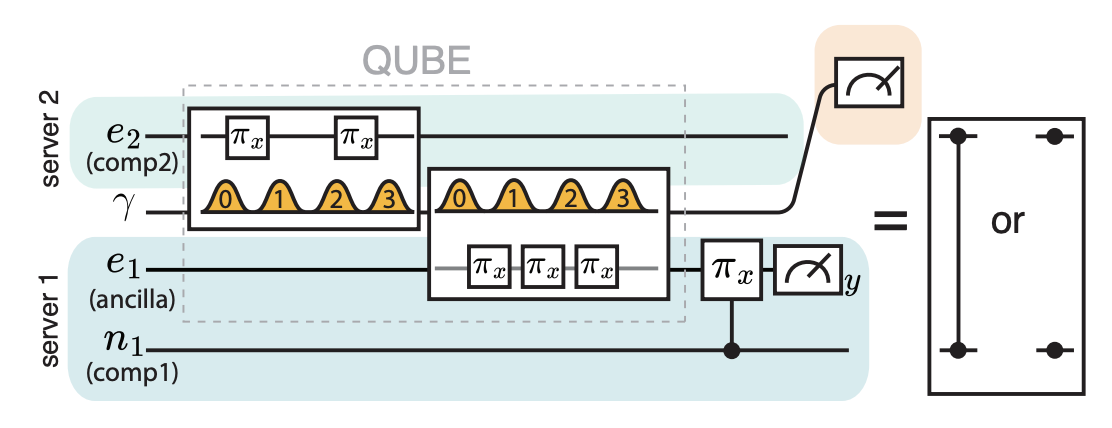

In [10]:
Image(filename='/Users/azizasuleymanzade/Dropbox (Personal)/Aziza/LukinLab/BlindComputing/SimulationCode_Aziza/Notebooks/FiguresJupyter/QUBE_gate.png')

In [176]:
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect', #'real'
                'tdinoise': 0, #np.pi/25, #'real'
                'mw': 'perfect', # or perfect
                'mw_noise': 0, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid, b16_mwfid] # default fidelities
               }
mu = 0.0003
Entange = 0 # choices are {0, 1}
# e1e2n2
een_initial = qt.tensor(rho_ideal_Xp, rho_ideal_Xp, rho_ideal_Xp)
Had = (1/np.sqrt(2))*qt.Qobj([[1, 1],[1, -1]])

### Try once perfect gates: entanglement on and off

In [186]:
Entange = 0
rho_final = sim2.two_qubit_internode_blind_gate(een_initial, imperfections, Entange, mu)
# transform for plotting
if Entange == 0:
    oper_transform = qt.tensor(ry(np.pi/2), ry(np.pi/2))

elif Entange == 1:
    oper_transform = qt.tensor(rx(np.pi/2), rx(np.pi/2))

rho = oper_transform*rho_final[1]*oper_transform.dag()

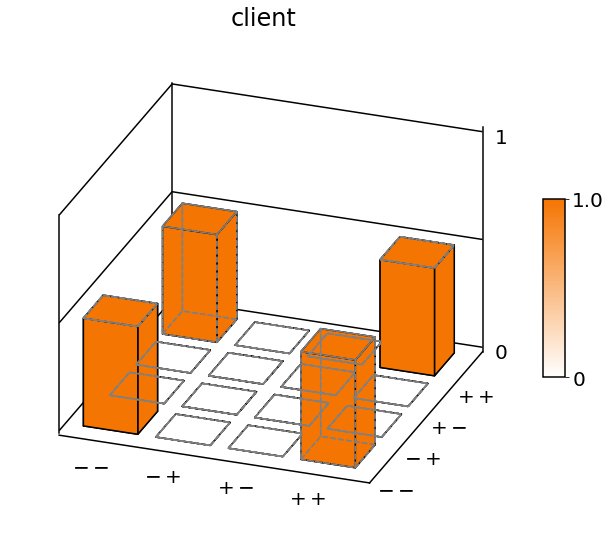

In [184]:
plot_from_rho_intranode_client(rho, 'client', 'entangling_phi=0.svg', (246/255, 133/255, 32/255), True)

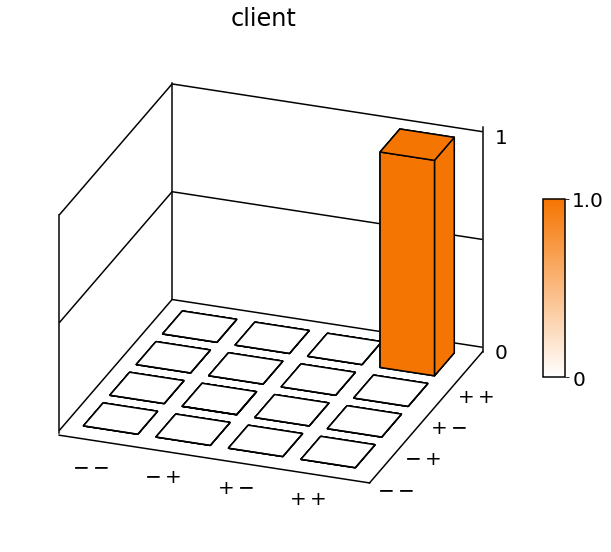

In [187]:
plot_from_rho_intranode_server(rho, 'client', 'entangling_phi=0.svg', (246/255, 133/255, 32/255), False)

### Run many averages: entanglement on and off

In [188]:
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.4, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid, b16_mwfid] # default fidelities
               }
mu = 0.07
# e1e2n2
een_initial = qt.tensor(rho_ideal_Xp, rho_ideal_Xp, rho_ideal_Xp)
Had = (1/np.sqrt(2))*qt.Qobj([[1, 1],[1, -1]])

##### Non-entangling gate

In [191]:
Entange = 0 # choices are {0, 1}
n_rounds = 40
rho_n_array_cl_0 = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0 = np.empty((0, 4, 4), dtype=complex)
fid_n_0 =  np.empty((0, 2), dtype=float)
el_rho_final_ideal_0 = qt.tensor(rho_ideal_Xp, rho_ideal_Xp)

for i in range(n_rounds):
    print(i)
    rho_output = sim2.two_qubit_internode_blind_gate(een_initial, imperfections, Entange, mu)
    rho_cl = rho_output[1]
    rho_s = rho_output[0]
    rho_n_array_s_0 = np.vstack([rho_n_array_s_0, [rho_s]])
    rho_n_array_cl_0 = np.vstack([rho_n_array_cl_0, [rho_cl]])
    fid = (qt.fidelity(qt.Qobj(rho_cl), el_rho_final_ideal_0))**2
    fid_n_0 = np.append(fid_n_0, fid)
    
fid_ave_0 = np.mean(fid_n_0, axis = 0)
fid_ave_std_0 = np.std(fid_n_0, axis = 0)/(np.sqrt(n_rounds))

print("Fidelity of an intranode gate = ", fid_ave_0, "+-", fid_ave_std_0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Fidelity of an intranode gate =  0.743319164216541 +- 0.0109613886113381


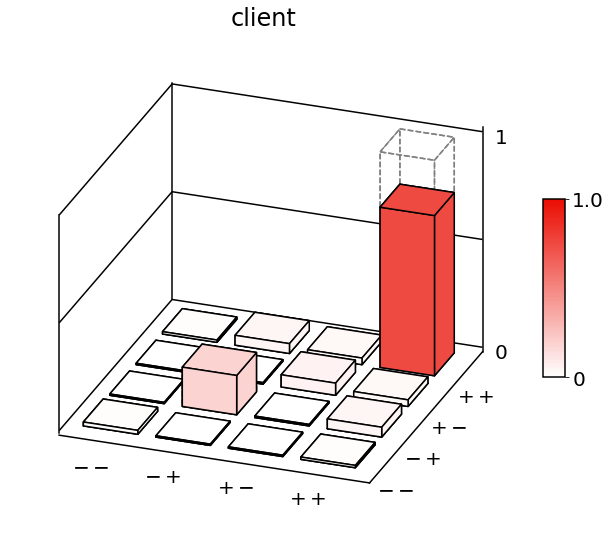

In [207]:
#  (241/255, 95/255, 88/255)
#         target = (116/255, 48/255, 98/255)

rho_ave_0 = np.mean(rho_n_array_cl_0, axis = 0)
oper_transform = qt.tensor(ry(np.pi/2), ry(np.pi/2))
rho = oper_transform*rho_ave_0*oper_transform.dag()
plot_from_rho_intranode_client(rho, 'client', 'nonentangling_client_internode.png', (241/255, 95/255, 88/255), False)

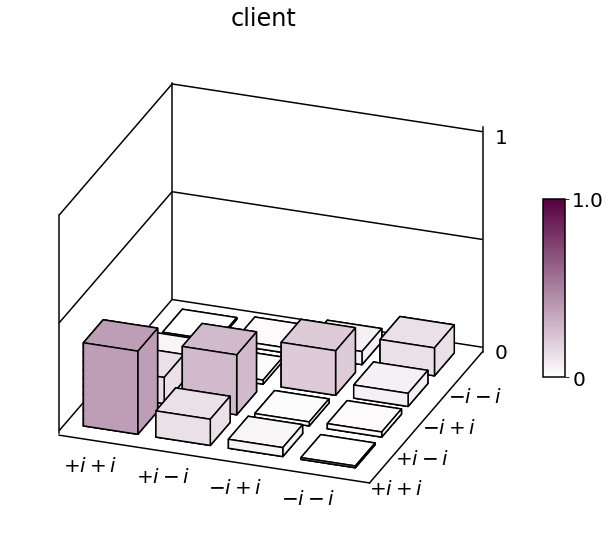

In [223]:
rho_ave_0 = np.mean(rho_n_array_s_0, axis = 0)
oper_transform = qt.tensor(ry(np.pi/2), ry(np.pi/2))
rho = oper_transform*rho_ave_0*oper_transform.dag()
plot_from_rho_internode_server(rho, 'client', 'nonentangling_server_internode.png', (116/255, 48/255, 98/255), False)

##### Entangling gate

In [192]:
Entange = 1 # choices are {0, 1}
n_rounds = 40
rho_n_array_cl_1 = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_1 = np.empty((0, 4, 4), dtype=complex)
oper_transform = qt.tensor(rx(np.pi/2), rx(np.pi/2))
fid_n_1 =  np.empty((0, 2), dtype=float)
el_rho_final_ideal_1 = qt.ket2dm((qt.tensor(psi_ideal_Yp, psi_ideal_Xm) + qt.tensor(psi_ideal_Ym, psi_ideal_Xp)).unit())
for i in range(n_rounds):
    # if i%100==0:
    print(i)
    rho_output = sim2.two_qubit_internode_blind_gate(een_initial, imperfections, Entange, mu)
    rho_cl = rho = oper_transform*rho_output[1]*oper_transform.dag()
    rho_s = rho = oper_transform*rho_output[0]*oper_transform.dag()
    rho_n_array_s_1 = np.vstack([rho_n_array_s_1, [rho_s]])
    rho_n_array_cl_1 = np.vstack([rho_n_array_cl_1, [rho_cl]])
    fid = (qt.fidelity(qt.Qobj(rho_cl), el_rho_final_ideal_1))**2
    fid_n_1 = np.append(fid_n_1, fid)
    
fid_ave_1 = np.mean(fid_n_1, axis = 0)
fid_ave_std_1 = np.std(fid_n_1, axis = 0)/(np.sqrt(n_rounds))

print("Fidelity of an intranode gate = ", fid_ave_1, "+-", fid_ave_std_1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Fidelity of an intranode gate =  0.7394275967549662 +- 0.01497899169537322


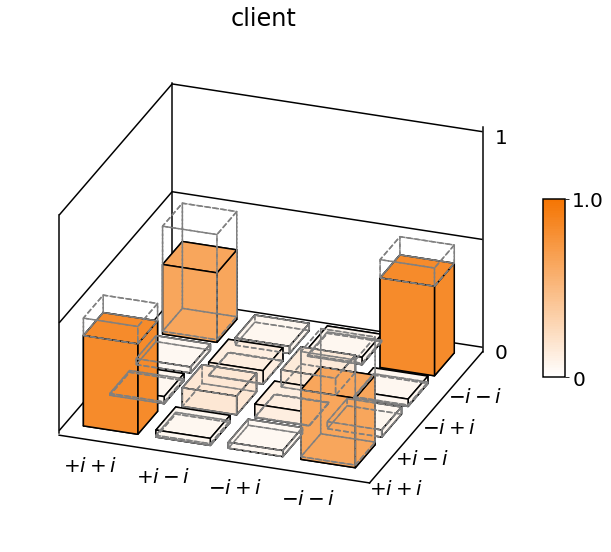

In [221]:
rho_ave_1 = np.mean(rho_n_array_cl_1, axis = 0)
plot_from_rho_internode_client(rho_ave_1, 'client', 'entangling_client_internode.png', (246/255, 133/255, 32/255), True)

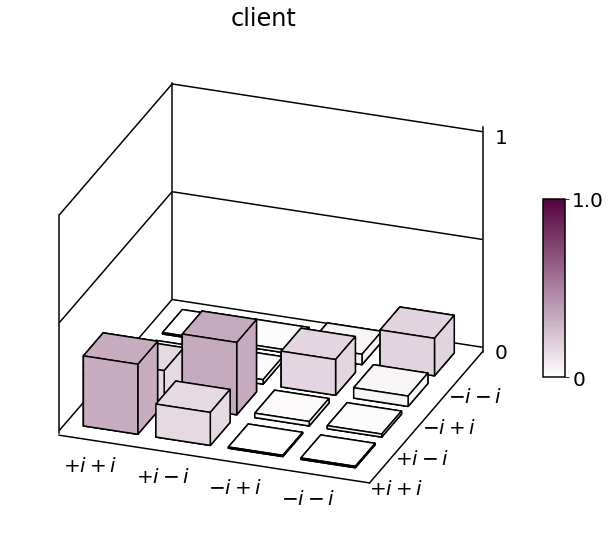

In [222]:
rho_ave_1 = np.mean(rho_n_array_s_1, axis = 0)
oper_transform = qt.tensor(ry(np.pi/2), ry(np.pi/2))
rho = oper_transform*rho_ave_1*oper_transform.dag()
plot_from_rho_internode_server(rho, 'client', 'nonentangling_server_internode.png', (116/255, 48/255, 98/255), False)

#### Blindness of Internode gate

In [227]:
rho_ave_phi_array =  np.empty((0, 4, 4), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

rho_ave_phi_array = np.array([np.mean(rho_n_array_s_0, axis = 0), np.mean(rho_n_array_s_1, axis = 0)])
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis_0 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_0]
eigen_phis_1 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_1]

factor = np.sqrt(len(eigen_phis_0))
eigen_phis = np.array([np.mean(eigen_phis_0, axis = 0), np.mean(eigen_phis_1, axis = 0)])
eigen_phis_std = np.array([np.std(eigen_phis_0, axis = 0)/factor,np.std(eigen_phis_1, axis = 0)/factor])

# # std of variability of eigenvalues of rho tot
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())
eigen_tot_std = np.sum(eigen_phis_std, axis = 0)

hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])

rho_tot_sigma_lambdas = eigen_tot_std
rho_tot_lambdas = eigen_tot
rho_lambdas = eigen_phis
rho_sigma_lambdas = eigen_phis_std

hv_std = holevo_bound_uncertainty_2q(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)

print('Holevo bound is = ', hv_tot, hv_std)

[0.1225666  0.20772972 0.23969314 0.43001054]
[0.00010581 0.00036394 0.00559411 0.00595298]
1.09910072334453 0.5715174822422067 0.4283957574333548 -0.15605444846358296
0.002581275028085083
[1.81626430e-04 3.39848116e-04 1.22627828e-01 8.76850698e-01]
[2.79764358e-05 6.36572090e-05 3.75668688e-03 3.78578209e-03]
7.613558564750983 6.9870117572805235 1.0986013002241632 -0.8685814566887237
[0.0039753  0.00870976 0.11626356 0.87105138]
[7.78358525e-05 3.00283088e-04 1.83741962e-03 2.16719840e-03]
4.527653909684676 3.7433108738126437 1.151895619676981 -0.8619456819859829
[0.00529988781086359, 0.003058885436984886]
Holevo bound is =  0.0495368847514317 0.003000554982563528


#### Full Gate set tomography

In [760]:
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect', #'real'
                'tdinoise': 0, #np.pi/25, #'real'
                'mw': 'perfect', # or perfect
                'mw_noise': 0, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [1, 1] # default fidelities
               }
mu = 0.0001
eln_initial = qt.tensor(rho_ideal_Xp, rho_ideal_Xp)

In [765]:
b16_mwfid_unitary = 0.99
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.4, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid_unitary, b16_mwfid_unitary] # default fidelities
               }
mu = 0.25
eln_initial = qt.tensor(rho_ideal_Xp, rho_ideal_Xp)

##### Non-entangling gate

In [766]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.linalg import sqrtm

def simulate_process_0(input_states):
    """
    Simulates the process and returns the output density matrices.
    """
    # # Simulate the process (replace with your actual simulation function)
    # # For demonstration, we'll use an identity operation
    # output_states = []
    # for rho_in in input_states:
    #     # Apply identity operation (or replace with your process)
    #     rho_out = rho_in.copy()
    #     # Ensure the dimensions are flattened
    #     rho_out = Qobj(rho_out.full(), dims=[[4], [4]])
    #     output_states.append(rho_out)

        ### THIS IS AN IDENTITY OPERATOR ON ALL INPUT STATES

    # input_states = [qt.tensor((qt.basis(2, 0) - qt.basis(2, 1)).unit(),(qt.basis(2, 0) + qt.basis(2, 1)).unit())]
    n_rounds = 1

    ## the arrays across the input states
    rho_array_cl_0_states = np.empty((0, n_rounds, 4, 4), dtype=complex)
    rho_array_s_0_states = np.empty((0, n_rounds, 4, 4), dtype=complex)
    for i_s in input_states:
        Entange = 0 # choices are {0, 1}
        n_rounds = 1
        i_s_3 = insert_qubit_in_x_plus_basis([i_s])[0]
        rho_n_array_cl_0 = np.empty((0, 4, 4), dtype=complex)
        rho_n_array_s_0 = np.empty((0, 4, 4), dtype=complex)
        for i in range(n_rounds):
            rho_output = sim2.two_qubit_internode_blind_gate(i_s_3, imperfections, Entange, mu)
            rho_cl = rho_output[1]
            rho_s = rho_output[0]
            rho_n_array_s_0 = np.vstack([rho_n_array_s_0, [rho_s]])
            rho_n_array_cl_0 = np.vstack([rho_n_array_cl_0, [rho_cl]])
        rho_array_s_0_states = np.vstack([rho_array_s_0_states, [rho_n_array_s_0]])
        rho_array_cl_0_states = np.vstack([rho_array_cl_0_states, [rho_n_array_cl_0]])

    rho_output_ave_states = np.mean(rho_array_cl_0_states, axis = 1)
    output_states = rho_output_ave_states

    return output_states

def simulate_process_1(input_states):
    """
    Simulates the process and returns the output density matrices.
    """
    # # Simulate the process (replace with your actual simulation function)
    # # For demonstration, we'll use an identity operation
    # output_states = []
    # for rho_in in input_states:
    #     # Apply identity operation (or replace with your process)
    #     rho_out = rho_in.copy()
    #     # Ensure the dimensions are flattened
    #     rho_out = Qobj(rho_out.full(), dims=[[4], [4]])
    #     output_states.append(rho_out)

        ### THIS IS AN IDENTITY OPERATOR ON ALL INPUT STATES

    # input_states = [qt.tensor((qt.basis(2, 0) - qt.basis(2, 1)).unit(),(qt.basis(2, 0) + qt.basis(2, 1)).unit())]
    n_rounds = 1

    ## the arrays across the input states
    rho_array_cl_0_states = np.empty((0, n_rounds, 4, 4), dtype=complex)
    rho_array_s_0_states = np.empty((0, n_rounds, 4, 4), dtype=complex)
    for i_s in input_states:
        Entange = 1 # choices are {0, 1}
        n_rounds = 1
        i_s_3 = insert_qubit_in_x_plus_basis([i_s])[0]
        rho_n_array_cl_0 = np.empty((0, 4, 4), dtype=complex)
        rho_n_array_s_0 = np.empty((0, 4, 4), dtype=complex)
        for i in range(n_rounds):
            rho_output = sim2.two_qubit_internode_blind_gate(i_s_3, imperfections, Entange, mu)
            rho_cl = rho_output[1]
            rho_s = rho_output[0]
            rho_n_array_s_0 = np.vstack([rho_n_array_s_0, [rho_s]])
            rho_n_array_cl_0 = np.vstack([rho_n_array_cl_0, [rho_cl]])
        rho_array_s_0_states = np.vstack([rho_array_s_0_states, [rho_n_array_s_0]])
        rho_array_cl_0_states = np.vstack([rho_array_cl_0_states, [rho_n_array_cl_0]])

    rho_output_ave_states = np.mean(rho_array_cl_0_states, axis = 1)
    output_states = rho_output_ave_states

    return output_states

In [712]:
def insert_qubit_in_x_plus_basis(input_states):
    """
    Transforms two-qubit input density matrices into three-qubit density matrices by inserting
    a qubit in the |+> (X-basis) state between the two qubits.
    """
    # Define the |+> state: |+> = (|0> + |1>)/sqrt(2)
    x_plus = (basis(2, 0) + basis(2, 1)).unit()
    x_plus_dm = ket2dm(x_plus)  # Convert |+> state to density matrix

    new_input_states = []
    for idx, state in enumerate(input_states):
        # Ensure the input is a Qobj
        if not isinstance(state, Qobj):
            raise ValueError(f"Input state {idx} is not a Qobj instance.")

        # Check if the input is a density matrix (operator)
        if not state.isoper:
            raise ValueError(f"Input state {idx} must be a density matrix (operator).")

        # Get the dimension of the Hilbert space
        d = state.shape[0]

        # Infer the number of qubits
        num_qubits = int(np.log2(d))
        if 2 ** num_qubits != d:
            raise ValueError(f"Input state {idx} does not represent a valid qubit system.")

        # Adjust dims if necessary
        if state.dims[0] == [d]:
            # Assume qubits of dimension 2
            state.dims = [ [2] * num_qubits, [2] * num_qubits ]

        # Tensor the input density matrix with the |+> density matrix
        # Current qubit order: q1, q2, ..., qN, x_plus
        three_qubit_state = tensor(state, x_plus_dm)

        # Permute qubits to have the order: q1, x_plus, q2, ..., qN
        # Indices: [0, N, 1, 2, ..., N-1] (for N >= 2)
        permute_order = [0] + [num_qubits] + list(range(1, num_qubits))
        three_qubit_state = three_qubit_state.permute(permute_order)

        new_input_states.append(three_qubit_state)

    return new_input_states

In [688]:
input_states_3 = insert_qubit_in_x_plus_basis(input_states)

In [767]:

# Define the two-qubit Pauli basis operators
pauli_ops = [qeye(2), sigmax(), sigmay(), sigmaz()]
basis_ops = []
dim = 4  # For two qubits
for op1 in pauli_ops:
    for op2 in pauli_ops:
        op = tensor(op1, op2)
        # Flatten the dimensions
        op = Qobj(op.full(), dims=[[dim], [dim]])
        basis_ops.append(op)
num_basis = len(basis_ops)

# Load or define the input and output density matrices
input_states = generate_input_states()
output_states = simulate_process_0(input_states)

In [751]:
def perform_qpt(input_states, output_states, basis_ops):
    """
    Performs quantum process tomography to reconstruct the chi matrix.
    """
    num_basis = len(basis_ops)
    dim = 4  # For two qubits
    num_elements = dim * dim

    # Number of equations
    num_eqs = len(input_states) * num_elements

    # Prepare the A matrix and b vector for linear equations
    A = np.zeros((num_eqs, num_basis ** 2), dtype=complex)
    b = np.zeros(num_eqs, dtype=complex)

    eq_idx = 0
    for rho_in, rho_out1 in zip(input_states, output_states):
        # Flatten output state
        rho_out = qt.Qobj(rho_out1, dims = [[2,2],[2,2]])
        rho_in = qt.Qobj(rho_in, dims = [[4],[4]])

        rho_out_vec = rho_out.full().reshape(-1)

        for i in range(num_elements):
            # Get the basis for the output density matrix element
            row = i // dim
            col = i % dim
            E_rc = basis(dim, row) * basis(dim, col).dag()
            # Flatten the dimensions
            E_rc = Qobj(E_rc.full(), dims=[[dim], [dim]])

            # Calculate the elements of A matrix
            for m in range(num_basis):
                for n in range(num_basis):
                    E_m = basis_ops[m]
                    E_n = basis_ops[n]

                    temp = (E_rc.dag() * E_m * rho_in * E_n.dag()).tr()
                    A[eq_idx, m * num_basis + n] = temp
            # Fill the b vector
            b[eq_idx] = rho_out_vec[i]
            eq_idx += 1

    # Solve the linear equation A * chi_vector = b
    chi_vector, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

    # Reshape chi_vector to chi_matrix
    chi_matrix = chi_vector.reshape((num_basis, num_basis))

    # Convert to Qobj for compatibility
    chi_matrix = Qobj(chi_matrix)

    return chi_matrix

In [768]:
# Perform quantum process tomography to reconstruct the chi matrix
chi_matrix_0 = perform_qpt(input_states, output_states, basis_ops)

# Display the chi matrix
print("Chi Matrix:")
print(chi_matrix_0)

Chi Matrix:
Quantum object: dims = [[16], [16]], shape = (16, 16), type = oper, isherm = False
Qobj data =
[[ 5.51738410e-01-8.13941507e-13j -2.06994917e-02+2.58393717e-02j
  -8.72260438e-03+1.90161997e-02j -7.06160348e-03+4.04223528e-02j
  -4.34758659e-04-8.12770771e-05j -2.86020263e-03+1.46640023e-03j
   4.01415778e-03-1.45078233e-02j  1.32314102e-02-3.63477849e-02j
  -2.28109614e-02-1.72148807e-02j  1.23934778e-03-2.76625644e-03j
   1.57476098e-02-1.95595188e-04j  7.75439868e-03+4.02536072e-03j
   4.10948308e-04-1.33772730e-02j -2.13453108e-02-2.38267011e-03j
   1.18161426e-03-1.63478520e-03j -1.07644076e-02+1.46922898e-02j]
 [-2.06994917e-02-2.58393717e-02j  1.35935577e-02+7.83168669e-13j
   3.95681083e-02+4.40853552e-03j -1.90161997e-02+7.27385206e-04j
   2.59803332e-04+1.77984041e-02j -1.96738500e-02+2.60944481e-03j
   5.24884359e-03-3.71282992e-03j  2.13617162e-02+1.57646951e-03j
  -1.21481151e-02+2.60760738e-03j  1.27478857e-02-6.72946300e-03j
  -3.70590768e-02-8.73773332e-03j 

In [763]:
# Perform quantum process tomography to reconstruct the chi matrix
chi_matrix_1 = perform_qpt(input_states, output_states, basis_ops)

# Display the chi matrix
print("Chi Matrix:")
print(chi_matrix_1)

Chi Matrix:
Quantum object: dims = [[16], [16]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[ 2.50000000e-01+1.96601994e-17j  5.55111512e-17+1.21430643e-16j
  -1.97613916e-16-1.98047597e-16j  2.49901171e-01-8.71698547e-17j
   1.59594560e-16-1.39645240e-16j -5.55111512e-17+1.60895602e-16j
   1.04083409e-16-1.03866568e-16j  8.32667268e-17+8.67361738e-18j
   3.12250226e-17+1.07552856e-16j  1.90819582e-17+2.40692882e-17j
  -9.71445147e-17+6.24500451e-17j  2.49800181e-16-6.50521303e-17j
   2.50000000e-01-8.77661659e-17j  3.98986399e-17-1.49186219e-16j
   2.08166817e-17+9.71445147e-17j -2.49901171e-01+3.39314622e-16j]
 [-2.22044605e-16+2.77555756e-17j  2.04697370e-16+1.02348685e-16j
  -2.14687277e-16-1.18427064e-16j  7.63278329e-17+1.38777878e-17j
  -1.80411242e-16+1.17961196e-16j -6.30361919e-17+5.02002547e-17j
  -6.24500451e-17+1.76941795e-16j -1.04083409e-16-8.93382590e-17j
  -4.34883656e-17+1.44582489e-16j -5.55111512e-17+5.37764278e-17j
   5.55111512e-17+2.28983499e-16j  

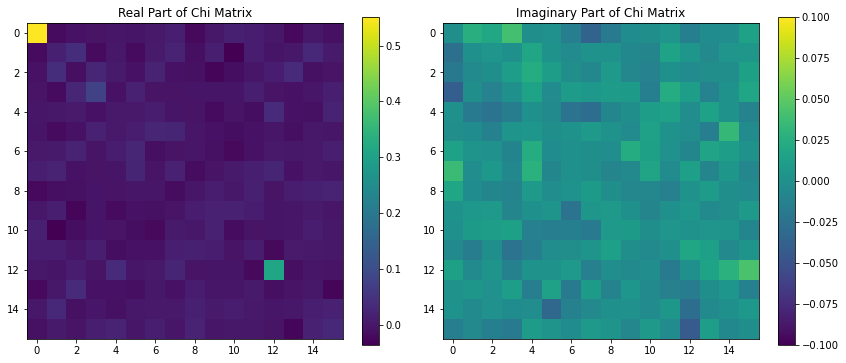

In [769]:

def plot_chi_matrix(chi):
    """
    Plots the real and imaginary parts of the chi matrix with adjusted color scales.
    """
    # If chi is a Qobj, convert it to a NumPy array
    if hasattr(chi, 'full'):
        chi_data = chi.full()
    else:
        chi_data = chi

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the real part
    im1 = axes[0].imshow(np.real(chi_data), cmap='viridis', interpolation='nearest')
    axes[0].set_title('Real Part of Chi Matrix')
    fig.colorbar(im1, ax=axes[0])

    # Plot the imaginary part with adjusted color scale
    # Set vmin and vmax to zero to display a uniform color
    im2 = axes[1].imshow(np.imag(chi_data), cmap='viridis', interpolation='nearest', vmin=0, vmax=0)
    axes[1].set_title('Imaginary Part of Chi Matrix')
    fig.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()
plot_chi_matrix(chi_matrix_0)

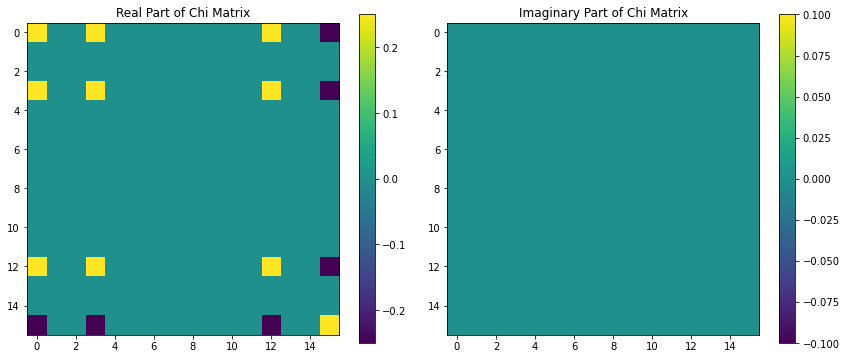

In [755]:
def plot_chi_matrix(chi):
    """
    Plots the real and imaginary parts of the chi matrix with adjusted color scales.
    """
    # If chi is a Qobj, convert it to a NumPy array
    if hasattr(chi, 'full'):
        chi_data = chi.full()
    else:
        chi_data = chi

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the real part
    im1 = axes[0].imshow(np.real(chi_data), cmap='viridis', interpolation='nearest')
    axes[0].set_title('Real Part of Chi Matrix')
    fig.colorbar(im1, ax=axes[0])

    # Plot the imaginary part with adjusted color scale
    # Set vmin and vmax to zero to display a uniform color
    im2 = axes[1].imshow(np.imag(chi_data), cmap='viridis', interpolation='nearest', vmin=0, vmax=0)
    axes[1].set_title('Imaginary Part of Chi Matrix')
    fig.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()
plot_chi_matrix(chi_matrix_cz)

In [758]:
process_fidelity(qt.Qobj(chi_matrix_1), qt.Qobj(chi_matrix_cz))

(0.5343694921848215-1.1155827147599004e-10j)

Chi Matrix:
[[ 0.25  0.    0.    0.25  0.    0.    0.    0.    0.    0.    0.    0.
   0.25  0.    0.   -0.25]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.   -0.  ]
 [ 0.25  0.    0.    0.25  0.    0.    0.    0.    0.    0.    0.    0.
   0.25  0.    0.   -0.25]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.   -0.  

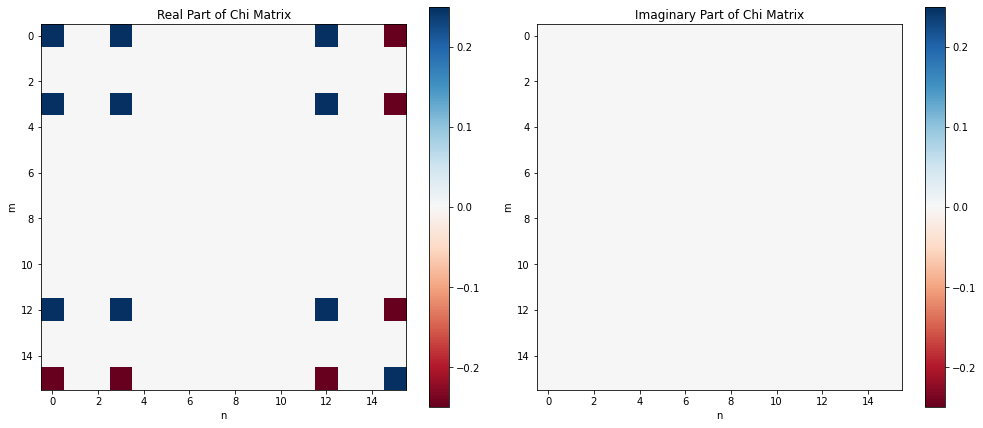

In [754]:
import numpy as np
from qutip import *


def CZ_gate_qutip():
    """
    Constructs the CZ gate using its explicit matrix representation.
    """
    CZ_matrix = np.diag([1, 1, 1, -1])
    CZ_gate = Qobj(CZ_matrix, dims=[[2,2],[2,2]])
    return CZ_gate

def pauli_matrices():
    """
    Returns the single-qubit Pauli matrices.
    """
    I = qeye(2)
    X = sigmax()
    Y = sigmay()
    Z = sigmaz()
    return [I, X, Y, Z]

def pauli_basis():
    """
    Constructs the two-qubit Pauli basis operators.
    """
    paulis = pauli_matrices()
    basis_ops = []
    for op1 in paulis:
        for op2 in paulis:
            E = tensor(op1, op2)
            basis_ops.append(E)
    return basis_ops

def compute_chi_matrix(U, basis_ops):
    """
    Computes the chi matrix for a unitary operation U in the given basis.
    """
    d = U.shape[0]  # Dimension of the Hilbert space
    u = []
    for E in basis_ops:
        u_k = (1 / d) * (E.dag() * U).tr()
        u.append(u_k)
    u = np.array(u)
    chi = np.outer(u, np.conj(u))
    return chi

def plot_chi_matrix(chi):
    """
    Plots the real and imaginary parts of the chi matrix.
    """
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the real part
    im1 = axes[0].imshow(np.real(chi), cmap='RdBu', interpolation='nearest', vmin=-0.25, vmax=0.25)
    axes[0].set_title('Real Part of Chi Matrix')
    axes[0].set_xlabel('n')
    axes[0].set_ylabel('m')
    fig.colorbar(im1, ax=axes[0])

    # Plot the imaginary part
    im2 = axes[1].imshow(np.imag(chi), cmap='RdBu', interpolation='nearest', vmin=-0.25, vmax=0.25)
    axes[1].set_title('Imaginary Part of Chi Matrix')
    axes[1].set_xlabel('n')
    axes[1].set_ylabel('m')
    fig.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()


# Define the CZ gate
CZ_gate = CZ_gate_qutip()

# Define the two-qubit Pauli basis
basis_ops = pauli_basis()

# Compute the chi matrix
chi_matrix_cz = compute_chi_matrix(CZ_gate, basis_ops)

# Display the chi matrix
print("Chi Matrix:")
print(chi_matrix_cz)

# Optionally, you can visualize the chi matrix
plot_chi_matrix(chi_matrix_cz)


## Deutsch-Jozsa algorithm

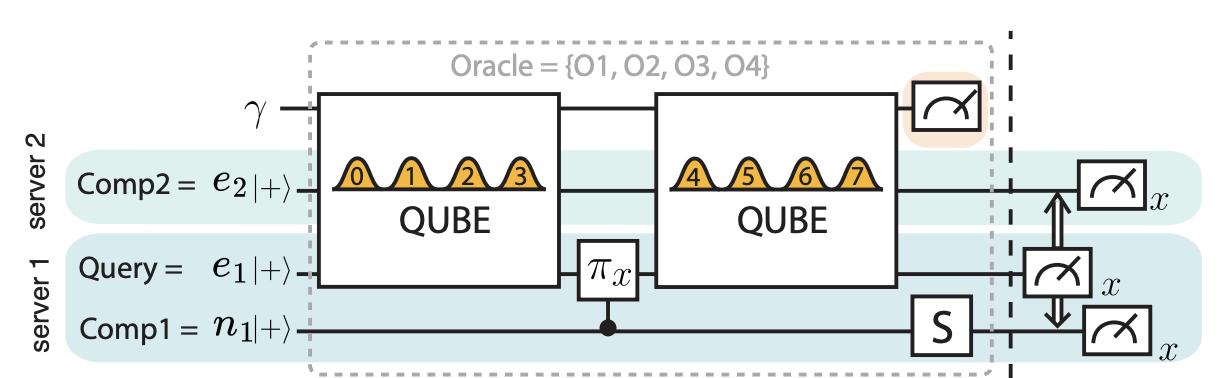

In [13]:
Image(filename='/Users/azizasuleymanzade/Dropbox (Personal)/Aziza/LukinLab/BlindComputing/SimulationCode_Aziza/Notebooks/FiguresJupyter/DJ_schematic.png')

### One perfect oracle run

In [527]:
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect', #'real'
                'tdinoise': 0, #np.pi/25, #'real'
                'mw': 'perfect', # or perfect
                'mw_noise': 0, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid, b16_mwfid] # default fidelities
               }
mu = 0.0003
# e1e2n2
een_initial = qt.tensor(rho_ideal_Xp, rho_ideal_Xp, rho_ideal_Xp)
Had = (1/np.sqrt(2))*qt.Qobj([[1, 1],[1, -1]])

In [110]:
b16_mwfid = 0.99
g12_mwfid = 0.99

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.2, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [0.99, 0.99] # default fidelities
               }
mu = 0.07

In [111]:
# 0 = {'B', 'A', 'D', 'C'}, 1 = {'F', 'E', 'H', 'G'}
Oracle_group = 0
output = sim2.DJ_blind_gate(een_initial, imperfections, Oracle_group, mu)
# transform for plotting
rho_final = output[0]
qube = output[1]
measurment1 = output[2]
measurment2 = output[3]

In [ ]:
ideal_states ={'A': qt.tensor(rho_ideal_Xp, rho_ideal_Yp), 
                'B': qt.tensor(rho_ideal_Xp, rho_ideal_Yp),
                'C': qt.tensor(rho_ideal_Xp, rho_ideal_Ym), 
                'D': qt.tensor(rho_ideal_Xp, rho_ideal_Ym),
                'E': qt.tensor(rho_ideal_Ym, rho_ideal_Yp), 
                'F': qt.tensor(rho_ideal_Ym, rho_ideal_Yp),
                'G': qt.tensor(rho_ideal_Ym, rho_ideal_Ym), 
                'H': qt.tensor(rho_ideal_Ym, rho_ideal_Ym)
               }

In [116]:
print(rho_final.ptrace([0]))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.53187576-1.37676245e-09j -0.35769549+6.42923979e-02j]
 [-0.35769549-6.42923994e-02j  0.46812424+1.37676245e-09j]]


In [118]:
qt.fidelity(rho_final.ptrace([1]), rho_ideal_Yp)**2

0.9991014980977659

In [113]:
oracle = get_oracle(qube, measurment1, measurment2, Oracle_group)
rho_final_s = rho_final
rho_final_cl = correction_DJ(rho_final_s, Oracle_group, qube, measurment1, measurment2)
print("Fidelity of", oracle, "oracle is  = ", fidelity_DJ_oracle(rho_final_cl, oracle))


Fidelity of B oracle is  =  0.8569665241874037


### Experiment in n rounds

In [49]:
b16_contrast = 13 # range 18 - 30
g12_contrast = 20 # range 12 - 20

siv_b.set_contrast(b16_contrast)
actual_contrast_b16 = siv_b.get_best_contrast()
print("B16 contrast is set to = ", actual_contrast_b16)

siv_a.set_contrast(g12_contrast)
actual_contrast_g12 = siv_a.get_best_contrast()
print("G12 contrast is set to = ", actual_contrast_g12)

new contrast 15.973777829652583
B16 contrast is set to =  15.973777829652583
new contrast 22.984605715760697
G12 contrast is set to =  22.984605715760697


In [51]:
b16_mwfid = 0.99
g12_mwfid = 0.99

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.2, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid, g12_mwfid] # default fidelities
               }
mu = 0.07

##### Run Oracle_group = 0

In [119]:
Oracle_group = 0
n_rounds = 40
rho_n_array_cl_0_A = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0_A = np.empty((0, 4, 4), dtype=complex)
fid_n_0_A =  np.empty((0, 2), dtype=float)

rho_n_array_cl_0_B = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0_B = np.empty((0, 4, 4), dtype=complex)
fid_n_0_B =  np.empty((0, 2), dtype=float)

rho_n_array_cl_0_C = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0_C = np.empty((0, 4, 4), dtype=complex)
fid_n_0_C =  np.empty((0, 2), dtype=float)

rho_n_array_cl_0_D = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0_D = np.empty((0, 4, 4), dtype=complex)
fid_n_0_D =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    if i%10==0:
        print(i)
    output = sim2.DJ_blind_gate(een_initial, imperfections, Oracle_group, mu)
    rho_final = output[0]
    qube = output[1]
    measurment1 = output[2]
    measurment2 = output[3]
    oracle = get_oracle(qube, measurment1, measurment2, Oracle_group)

    rho_s = rho_final
    rho_cl = correction_DJ(rho_s, Oracle_group, qube, measurment1, measurment2)

    if oracle == "A":
        rho_n_array_s_0_A = np.vstack([rho_n_array_s_0_A, [rho_s]])
        rho_n_array_cl_0_A = np.vstack([rho_n_array_cl_0_A, [rho_cl]])
        fid = fidelity_DJ_oracle(rho_cl, oracle)
        fid_n_0_A = np.append(fid_n_0_A, fid)
    elif oracle == "B":
        rho_n_array_s_0_B = np.vstack([rho_n_array_s_0_B, [rho_s]])
        rho_n_array_cl_0_B = np.vstack([rho_n_array_cl_0_B, [rho_cl]])
        fid = fidelity_DJ_oracle(rho_cl, oracle)
        fid_n_0_B = np.append(fid_n_0_B, fid)
    elif oracle == "C":
        rho_n_array_s_0_C = np.vstack([rho_n_array_s_0_C, [rho_s]])
        rho_n_array_cl_0_C = np.vstack([rho_n_array_cl_0_C, [rho_cl]])
        fid = fidelity_DJ_oracle(rho_cl, oracle)
        fid_n_0_C = np.append(fid_n_0_C, fid)
    elif oracle == "D":
        rho_n_array_s_0_D = np.vstack([rho_n_array_s_0_D, [rho_s]])
        rho_n_array_cl_0_D = np.vstack([rho_n_array_cl_0_D, [rho_cl]])
        fid = fidelity_DJ_oracle(rho_cl, oracle)
        fid_n_0_D = np.append(fid_n_0_D, fid)

    
fid_ave_0_A = np.mean(fid_n_0_A, axis = 0)
fid_ave_std_0_A = np.std(fid_n_0_A, axis = 0)/(np.sqrt(len(fid_n_0_A)))
print("Fidelity of A oracle gate = ", fid_ave_0_A, "+-", fid_ave_std_0_A)

fid_ave_0_B = np.mean(fid_n_0_B, axis = 0)
fid_ave_std_0_B = np.std(fid_n_0_B, axis = 0)/(np.sqrt(len(fid_n_0_B)))
print("Fidelity of B oracle gate = ", fid_ave_0_B, "+-", fid_ave_std_0_B)

fid_ave_0_C = np.mean(fid_n_0_C, axis = 0)
fid_ave_std_0_C = np.std(fid_n_0_C, axis = 0)/(np.sqrt(len(fid_n_0_C)))
print("Fidelity of C oracle gate = ", fid_ave_0_C, "+-", fid_ave_std_0_C)

fid_ave_0_D = np.mean(fid_n_0_D, axis = 0)
fid_ave_std_0_D = np.std(fid_n_0_D, axis = 0)/(np.sqrt(len(fid_n_0_D)))
print("Fidelity of D oracle gate = ", fid_ave_0_D, "+-", fid_ave_std_0_D)

0
10
20
30
Fidelity of A oracle gate =  0.80159416566498 +- 0.029146455436403068
Fidelity of B oracle gate =  0.8004045917248784 +- 0.017819378729954403
Fidelity of C oracle gate =  0.8138711288313875 +- 0.012036123866035758
Fidelity of D oracle gate =  0.7865912080837887 +- 0.020427487960652427


##### Run Oracle_group = 1

In [414]:
Oracle_group = 1
n_rounds = 40
rho_n_array_cl_0_E = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0_E = np.empty((0, 4, 4), dtype=complex)
fid_n_0_E =  np.empty((0, 2), dtype=float)

rho_n_array_cl_0_F = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0_F = np.empty((0, 4, 4), dtype=complex)
fid_n_0_F =  np.empty((0, 2), dtype=float)

rho_n_array_cl_0_G = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0_G = np.empty((0, 4, 4), dtype=complex)
fid_n_0_G =  np.empty((0, 2), dtype=float)

rho_n_array_cl_0_H = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0_H = np.empty((0, 4, 4), dtype=complex)
fid_n_0_H =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    if i%10==0:
        print(i)
    output = sim2.DJ_blind_gate(een_initial, imperfections, Oracle_group, mu)
    rho_final = output[0]
    # measurement values s1, s2, s3
    qube = output[1]
    measurment1 = output[2]
    measurment2 = output[3]
    oracle = get_oracle(qube, measurment1, measurment2, Oracle_group)

    rho_s = rho_final
    rho_cl = correction_DJ(rho_s, Oracle_group, qube, measurment1, measurment2)

    if oracle == "E":
        rho_n_array_s_0_E = np.vstack([rho_n_array_s_0_E, [rho_s]])
        rho_n_array_cl_0_E = np.vstack([rho_n_array_cl_0_E, [rho_cl]])
        fid = fidelity_DJ_oracle(rho_cl, oracle)
        fid_n_0_E = np.append(fid_n_0_E, fid)
    elif oracle == "F":
        rho_n_array_s_0_F = np.vstack([rho_n_array_s_0_F, [rho_s]])
        rho_n_array_cl_0_F = np.vstack([rho_n_array_cl_0_F, [rho_cl]])
        fid = fidelity_DJ_oracle(rho_cl, oracle)
        fid_n_0_F = np.append(fid_n_0_F, fid)
    elif oracle == "G":
        rho_n_array_s_0_G = np.vstack([rho_n_array_s_0_G, [rho_s]])
        rho_n_array_cl_0_G = np.vstack([rho_n_array_cl_0_G, [rho_cl]])
        fid = fidelity_DJ_oracle(rho_cl, oracle)
        fid_n_0_G = np.append(fid_n_0_G, fid)
    elif oracle == "H":
        rho_n_array_s_0_H = np.vstack([rho_n_array_s_0_H, [rho_s]])
        rho_n_array_cl_0_H = np.vstack([rho_n_array_cl_0_H, [rho_cl]])
        fid = fidelity_DJ_oracle(rho_cl, oracle)
        fid_n_0_H = np.append(fid_n_0_H, fid)

    
fid_ave_0_E = np.mean(fid_n_0_E, axis = 0)
fid_ave_std_0_E = np.std(fid_n_0_E, axis = 0)/(np.sqrt(len(fid_n_0_E)))
print("Fidelity of E oracle gate = ", fid_ave_0_E, "+-", fid_ave_std_0_E)

fid_ave_0_F = np.mean(fid_n_0_F, axis = 0)
fid_ave_std_0_F = np.std(fid_n_0_F, axis = 0)/(np.sqrt(len(fid_n_0_F)))
print("Fidelity of F oracle gate = ", fid_ave_0_F, "+-", fid_ave_std_0_F)

fid_ave_0_G = np.mean(fid_n_0_G, axis = 0)
fid_ave_std_0_G = np.std(fid_n_0_G, axis = 0)/(np.sqrt(len(fid_n_0_G)))
print("Fidelity of G oracle gate = ", fid_ave_0_G, "+-", fid_ave_std_0_G)

fid_ave_0_H = np.mean(fid_n_0_H, axis = 0)
fid_ave_std_0_H = np.std(fid_n_0_H, axis = 0)/(np.sqrt(len(fid_n_0_H)))
print("Fidelity of H oracle gate = ", fid_ave_0_H, "+-", fid_ave_std_0_H)

0


KeyboardInterrupt: 

##### Calculate the probabilities of detecting Balanced vs Constant

In [19]:
constant = qt.tensor(rho_ideal_Ym, rho_ideal_Ym)

print(constant.ptrace([1]))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5+0.j  0. +0.5j]
 [0. -0.5j 0.5+0.j ]]


In [511]:
Bcor = qt.Qobj(np.round(A[0], 2), dims=[[2, 2], [2, 2]])
print(Bcor.ptrace([0]))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 +0.j   0.04-0.36j]
 [0.04+0.36j 0.5 +0.j  ]]


In [512]:
Bcor = qt.Qobj(np.round(C[0], 2), dims=[[2, 2], [2, 2]])
print(Bcor.ptrace([0]))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 +0.j   0.02-0.36j]
 [0.02+0.36j 0.5 +0.j  ]]


In [513]:
qt.fidelity(Bcor, constant)**2

0.1400000035045843

In [521]:
blah = qt.Qobj(np.round(qt.Qobj(rho_n_array_cl_0_A[0], dims=[[2, 2], [2, 2]]).ptrace([1]), 2))
blah_cor = z_rotation*blah*z_rotation.dag()
print(blah)
print(blah_cor)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5 +0.j  -0.01-0.5j]
 [-0.01+0.5j  0.5 +0.j ]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5+0.j   -0.5+0.01j]
 [-0.5-0.01j  0.5+0.j  ]]


In [522]:
print(rho_ideal_Xp)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]


In [526]:
qt.fidelity(blah, rho_ideal_Ym)**2

0.0

In [524]:
qt.fidelity(blah_cor, rho_ideal_Ym)**2

0.5100000152439846

In [120]:
# Define the Z-rotation for the first qubit (pi/2 rotation)
z_rotation = (-1j * np.pi / 4 * qt.sigmaz()).expm()  # Rotation by pi/2

# Identity on the second qubit
identity_second_qubit = Id2

# Apply rotation to only the first qubit
rotation_operator = qt.tensor(z_rotation, identity_second_qubit)
constant = qt.tensor(rho_ideal_Ym, rho_ideal_Ym)


A = [rotation_operator * qt.Qobj(rho, dims=[[2, 2], [2, 2]]) * rotation_operator.dag() for rho in rho_n_array_cl_0_A]
prob_constant_A = [1 - qt.fidelity(A_i, constant)**2 for A_i in A]
prob_A = np.mean(prob_constant_A, axis = 0)
std_A = np.std(prob_constant_A, axis = 0)/(np.sqrt(len(prob_constant_A)))
print("prob_balanced_A", prob_A, "+-", std_A)

B = [rotation_operator * qt.Qobj(rho, dims=[[2, 2], [2, 2]]) * rotation_operator.dag() for rho in rho_n_array_cl_0_B]
prob_constant_B = [1 - qt.fidelity(B_i, constant)**2 for B_i in B]
prob_B = np.mean(prob_constant_B, axis = 0)
std_B = np.std(prob_constant_B, axis = 0)/(np.sqrt(len(prob_constant_B)))
print("prob_balanced_B", prob_B, "+-", std_B)

C = [rotation_operator * qt.Qobj(rho, dims=[[2, 2], [2, 2]]) * rotation_operator.dag() for rho in rho_n_array_cl_0_C]
prob_constant_C = [1 - qt.fidelity(C_i, constant)**2 for C_i in C]
prob_C = np.mean(prob_constant_C, axis = 0)
std_C = np.std(prob_constant_C, axis = 0)/(np.sqrt(len(prob_constant_A)))
print("prob_balanced_C", prob_C, "+-", std_C)

D = [rotation_operator * qt.Qobj(rho, dims=[[2, 2], [2, 2]]) * rotation_operator.dag() for rho in rho_n_array_cl_0_D]
prob_constant_D = [1 - qt.fidelity(D_i, constant)**2 for D_i in D]
prob_D = np.mean(prob_constant_D, axis = 0)
std_D = np.std(prob_constant_D, axis = 0)/(np.sqrt(len(prob_constant_A)))
print("prob_balanced_D", prob_D, "+-", std_D)

E = [qt.Qobj(rho, dims=[[2, 2], [2, 2]]) for rho in rho_n_array_cl_0_E]
prob_constant_E = [1 - qt.fidelity(E_i, constant)**2 for E_i in E]
prob_E = np.mean(prob_constant_E, axis = 0)
std_E = np.std(prob_constant_E, axis = 0)/(np.sqrt(len(prob_constant_A)))
print("prob_balanced_E", prob_E, "+-", std_E)

F = [qt.Qobj(rho, dims=[[2, 2], [2, 2]]) for rho in rho_n_array_cl_0_F]
prob_constant_F = [1 - qt.fidelity(F_i, constant)**2 for F_i in F]
prob_F = np.mean(prob_constant_F, axis = 0)
std_F = np.std(prob_constant_F, axis = 0)/(np.sqrt(len(prob_constant_A)))
print("prob_balanced_E", prob_F, "+-", std_F)

G = [qt.Qobj(rho, dims=[[2, 2], [2, 2]]) for rho in rho_n_array_cl_0_G]
prob_constant_G = [qt.fidelity(G_i, constant)**2 for G_i in G]
prob_G = np.mean(prob_constant_G, axis = 0)
std_G = np.std(prob_constant_G, axis = 0)/(np.sqrt(len(prob_constant_A)))
print("prob_balanced_E", prob_G, "+-", std_G)

H = [qt.Qobj(rho, dims=[[2, 2], [2, 2]]) for rho in rho_n_array_cl_0_H]
prob_constant_H = [qt.fidelity(H_i, constant)**2 for H_i in H]
prob_H = np.mean(prob_constant_H, axis = 0)
std_H = np.std(prob_constant_H, axis = 0)/(np.sqrt(len(prob_constant_A)))
print("prob_balanced_H", prob_H, "+-", std_H)

prob_balanced_A 0.9992502397209775 +- 0.00045314592191797546
prob_balanced_B 0.999432918770813 +- 0.00010462799378306403
prob_balanced_C 0.8155841052849891 +- 0.013331855423440698
prob_balanced_D 0.789009160637894 +- 0.020123161335264463


NameError: name 'rho_n_array_cl_0_E' is not defined

In [401]:
## O1
np.mean(prob_G + prob_H)/2

0.7421582395981783

In [400]:
np.mean(std_G+ std_H)

0.06678675196151942

### O1: A and B

In [382]:
fid_ave_O1 = (fid_ave_0_A + fid_ave_0_B)/2
fid_std_O1 = fid_ave_std_0_A + fid_ave_std_0_B
print("Fidelity of two state which correspond to O1 oracle = " ,fid_ave_O1, "+- ", fid_std_O1)
rho_n_array_s_O1 = np.concatenate((rho_n_array_s_0_A, rho_n_array_s_0_B), axis=0)
rho_n_array_cl_O1 = np.concatenate((rho_n_array_cl_0_A, rho_n_array_cl_0_B), axis=0)
rho_ave_1 = np.mean(rho_n_array_cl_O1, axis = 0)


Fidelity of two state which correspond to O1 oracle =  0.7430126646523514 +-  0.07101884688590482


### O2: C and D

In [383]:
fid_ave_O2 = (fid_ave_0_C + fid_ave_0_D)/2
fid_std_O2 = fid_ave_std_0_C + fid_ave_std_0_D
print("Fidelity of O2 oracle = " ,fid_ave_O2, "+- ", fid_std_O2)
rho_n_array_s_O2 = np.concatenate((rho_n_array_s_0_C, rho_n_array_s_0_D), axis=0)


Fidelity of O2 oracle =  0.7613120352217431 +-  0.0779491760327268


### O3: E and F

In [384]:
fid_ave_O3 = (fid_ave_0_E + fid_ave_0_F)/2
fid_std_O3 = fid_ave_std_0_E + fid_ave_std_0_F
print("Fidelity of O3 oracle = " ,fid_ave_O3, "+- ", fid_std_O3)
rho_n_array_s_O3 = np.concatenate((rho_n_array_s_0_E, rho_n_array_s_0_F), axis=0)


Fidelity of O3 oracle =  0.7003872131266924 +-  0.06479169931415846


### O4: G and H

In [385]:
fid_ave_O4 = (fid_ave_0_G + fid_ave_0_H)/2
fid_std_O4 = fid_ave_std_0_G + fid_ave_std_0_H
print("Fidelity of O4 oracle = " ,fid_ave_O4, "+- ", fid_std_O4)
rho_n_array_s_O4 = np.concatenate((rho_n_array_s_0_G, rho_n_array_s_0_H), axis=0)


Fidelity of O4 oracle =  0.7421582395981783 +-  0.05204065311652389


#### Calcualate blindness for O1 and O3

In [386]:
rho_ave_phi_array =  np.empty((0, 4, 4), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

rho_ave_phi_array = np.array([np.mean(rho_n_array_s_O1, axis = 0), np.mean(rho_n_array_s_O3, axis = 0)])
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis_01 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_O1]
eigen_phis_03 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_O3]

factor = np.sqrt(len(eigen_phis_01))
eigen_phis = np.array([np.mean(eigen_phis_01, axis = 0), np.mean(eigen_phis_03, axis = 0)])
eigen_phis_std = np.array([np.std(eigen_phis_01, axis = 0)/factor,np.std(eigen_phis_03, axis = 0)/factor])

# # std of variability of eigenvalues of rho tot
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())
eigen_tot_std = np.sum(eigen_phis_std, axis = 0)

hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])

rho_tot_sigma_lambdas = eigen_tot_std
rho_tot_lambdas = eigen_tot
rho_lambdas = eigen_phis
rho_sigma_lambdas = eigen_phis_std

hv_std = holevo_bound_uncertainty_2q(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_lambdas)

print('Holevo bound between O1 and O3 is = ', hv_tot, hv_std)

[0.00172739 0.00239357 0.35284057 0.64303848]
[1.08957653e-05 1.81770331e-05 1.11287563e-02 1.11498545e-02]
5.361141604060492 5.034971200187489 0.04173897951840755 -0.5584492806726842
0.0062448739076314715
[8.80227091e-05 1.51432535e-04 1.52191361e-01 8.47569184e-01]
[8.80227091e-05 1.51432535e-04 1.52191361e-01 8.47569184e-01]
8.337915718374799 7.795370344476924 0.882616595702105 -0.834617189636757
[7.27623984e-05 1.37354375e-04 1.42489924e-01 8.57299960e-01]
[7.27623984e-05 1.37354375e-04 1.42489924e-01 8.57299960e-01]
8.528311241119637 7.892946292914035 0.9484839928741957 -0.8460325895307126
[0.7200377805767791, 0.7377888506124187]
Holevo bound between O1 and O3 is =  0.01723088690022645 0.25780452487639294


#### Calcualate blindness for O2 and O4

In [389]:
rho_ave_phi_array =  np.empty((0, 4, 4), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

rho_ave_phi_array = np.array([np.mean(rho_n_array_s_O2, axis = 0), np.mean(rho_n_array_s_O4, axis = 0)])
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis_02 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_O2]
eigen_phis_04 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_O4]

factor = np.sqrt(len(eigen_phis_02))
eigen_phis = np.array([np.mean(eigen_phis_02, axis = 0), np.mean(eigen_phis_04, axis = 0)])
eigen_phis_std = np.array([np.std(eigen_phis_02, axis = 0)/factor,np.std(eigen_phis_04, axis = 0)/factor])

# # std of variability of eigenvalues of rho tot
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())
eigen_tot_std = np.sum(eigen_phis_std, axis = 0)

hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])

rho_tot_sigma_lambdas = eigen_tot_std
rho_tot_lambdas = eigen_tot
rho_lambdas = eigen_phis
rho_sigma_lambdas = eigen_phis_std

hv_std = holevo_bound_uncertainty_2q(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_lambdas)

print('Holevo bound between O1 and O3 is = ', hv_tot, hv_std)

[0.00104541 0.00170956 0.40905197 0.58819305]
[2.09498057e-05 4.26642126e-05 1.37599387e-02 1.38112549e-02]
5.863344771406504 5.371518168131022 -0.10608694574700184 -0.46929993533212644
0.006649051755711932
[1.48632753e-04 2.44704325e-04 1.51237967e-01 8.48368696e-01]
[1.48632753e-04 2.44704325e-04 1.51237967e-01 8.48368696e-01]
7.814032036986854 7.315459913516571 0.8889007438477792 -0.8355600455286339
[1.33309428e-04 2.24888403e-04 1.59191030e-01 8.40450772e-01]
[1.33309428e-04 2.24888403e-04 1.59191030e-01 8.40450772e-01]
7.922837609247894 7.3999062637550175 0.8376503516549179 -0.8261831025056641
[0.7215013524891672, 0.7070570060118851]
Holevo bound between O1 and O3 is =  0.0008590628895912555 0.25263624661039225


#### Calcualate blindness for O1 and O2: test (distinguishable to the server)

In [390]:
rho_ave_phi_array =  np.empty((0, 4, 4), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

rho_ave_phi_array = np.array([np.mean(rho_n_array_s_O1, axis = 0), np.mean(rho_n_array_s_O2, axis = 0)])
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis_01 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_O1]
eigen_phis_02 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_O2]

factor = np.sqrt(len(eigen_phis_01))
eigen_phis = np.array([np.mean(eigen_phis_01, axis = 0), np.mean(eigen_phis_02, axis = 0)])
eigen_phis_std = np.array([np.std(eigen_phis_01, axis = 0)/factor,np.std(eigen_phis_02, axis = 0)/factor])

# # std of variability of eigenvalues of rho tot
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())
eigen_tot_std = np.sum(eigen_phis_std, axis = 0)

hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])

rho_tot_sigma_lambdas = eigen_tot_std
rho_tot_lambdas = eigen_tot
rho_lambdas = eigen_phis
rho_sigma_lambdas = eigen_phis_std

hv_std = holevo_bound_uncertainty_2q(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_lambdas)

print('Holevo bound between O1 and O2 is = ', hv_tot, hv_std)

[0.20628953 0.21953104 0.28172721 0.29245222]
[2.35962271e-05 3.95255046e-05 1.12783543e-02 1.13264359e-02]
0.5784746190528045 0.5162616546294698 0.26681601285298484 0.22945396656857686
0.0039762318635944965
[8.80227091e-05 1.51432535e-04 1.52191361e-01 8.47569184e-01]
[8.80227091e-05 1.51432535e-04 1.52191361e-01 8.47569184e-01]
8.337915718374799 7.795370344476924 0.882616595702105 -0.834617189636757
[1.48632753e-04 2.44704325e-04 1.51237967e-01 8.48368696e-01]
[1.48632753e-04 2.44704325e-04 1.51237967e-01 8.48368696e-01]
7.814032036986854 7.315459913516571 0.8889007438477792 -0.8355600455286339
[0.7200377805767791, 0.7215013524891672]
Holevo bound between O1 and O2 is =  0.6696949345738712 0.2548616749605265
